In [ ]:
### This script produces the results reported in: 
### Adeyemi, T., Ngobigha, F., & Ez-Zizi, A. (2025). Future-proofed intrusion detection for Internet of Things 
### with machine learning. In 2025 IEEE 4th International Conference on AI in Cybersecurity (ICAIC) (pp. 1-6). IEEE.
### https://doi.org/10.1109/ICAIC63015.2025.10848845. 
###  
### The code in its current form was primarily written by Dr Adnane Ez-zizi. Taiwo Adeyemi made significant contributions 
### by developing the code for Section III (Testing batch size effect on F1-score for binary classification) and shaping 
### previous iterations of the analyses. Script last modified on 02/02/2025.
###
### The dataset used in this script is the CICIoT2023 dataset, which is available at: https://www.unb.ca/cic/datasets/iotdataset-2023.html

In [ ]:
# Uncomment to install the necessary packages if necessary 
# !pip install tqdm seaborn graphviz imblearn xgboost scikit-learn-intelex modin[ray]

In [1]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import math
import os
import time
import pickle
from tqdm import tqdm
import seaborn as sns
from graphviz import Source
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, ParameterGrid
from sklearn.tree import DecisionTreeClassifier, export_graphviz
#from graphviz import Source
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline

# Uncomment this if you have Intel® Extension for Scikit-learn* (see https://www.intel.com/content/www/us/en/developer/tools/oneapi/ai-tools-selector.html)
from sklearnex import patch_sklearn
patch_sklearn()

import warnings
warnings.filterwarnings('ignore')

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Useful Functions

In [ ]:
def clean_data(df):

    """
    Function to clean the data by removing unnecessary columns and transforming features

    Args:
    df: DataFrame containing the data (balanced or full datasets)

    Returns:
    df: Cleaned dataFrame
    """

    # Remove invariant columns
    df.drop(['ece_flag_number', 'cwr_flag_number', 'Telnet', 'SMTP', 'DHCP'], axis=1, inplace=True)

    # Since most of the values of Drate are 0, we will convert this to a binary feature
    df['Drate'] = df['Drate'].apply(lambda x: 0 if x == 0 else 1)

    # Also remove since major protocol types are encoded in other columns
    df.drop(['Protocol Type'],  axis=1, inplace=True)

    # Apply log transform to the following highly skewed features: ack_count, syn_count, fin_count, urg_count and rst_count
    for col in ['ack_count', 'syn_count', 'fin_count', 'urg_count', 'rst_count']:
        df[col] = np.log(df[col] + 1) # Add 1 to avoid log(0)

    return df

In [ ]:
# Function to prepare data for binary classification models
def prepare_data_for_classification(full_data, outcome_num = 2):
    """
    Function to prepare data for binary classification models
    
    Args:
        full_data (DataFrame): DataFrame containing all the data
        outcome_num (int): number of classes in the classification problem: 2, 8 or 34
    
    Returns:
        X (DataFrame): DataFrame containing the features
        y (DataFrame): One-clumn dataframe containing the target values
    """

    data = full_data.copy()
    
    # Map class names to labels
    if outcome_num == 2: 
        # Create a dictionary to map 'BenignTraffic' to 'begin' and other classes to 'attack'
        class_mapping = {'DictionaryBruteForce': 'attack',
                        'Backdoor_Malware': 'attack',
                        'Uploading_Attack': 'attack',
                        'CommandInjection': 'attack',
                        'VulnerabilityScan': 'attack',
                        'Recon-PingSweep': 'attack',
                        'SqlInjection': 'attack',
                        'BrowserHijacking': 'attack',
                        'DDoS-SlowLoris': 'attack',
                        'DDoS-HTTP_Flood': 'attack',
                        'Mirai-udpplain': 'attack',
                        'DDoS-UDP_Fragmentation': 'attack',
                        'DDoS-UDP_Flood': 'attack',
                        'MITM-ArpSpoofing': 'attack',
                        'XSS': 'attack',
                        'DNS_Spoofing': 'attack',
                        'Recon-HostDiscovery': 'attack',
                        'Recon-OSScan': 'attack',
                        'DoS-HTTP_Flood': 'attack',
                        'DDoS-ACK_Fragmentation': 'attack',
                        'Mirai-greip_flood': 'attack',
                        'Recon-PortScan': 'attack',
                        'DDoS-ICMP_Fragmentation': 'attack',
                        'DoS-UDP_Flood': 'attack',
                        'DoS-SYN_Flood': 'attack',
                        'DDoS-PSHACK_Flood': 'attack',
                        'DDoS-SynonymousIP_Flood': 'attack',
                        'DDoS-TCP_Flood': 'attack',
                        'DDoS-SYN_Flood': 'attack',
                        'Mirai-greeth_flood': 'attack',
                        'DDoS-ICMP_Flood': 'attack',
                        'DoS-TCP_Flood': 'attack',
                        'DDoS-RSTFINFlood': 'attack',
                        'BenignTraffic': 'benign'}
        data['label'] = data['label'].map(class_mapping)
    elif outcome_num == 8:
        class_mapping = {
            'DictionaryBruteForce': 'brute_Force',
            'Backdoor_Malware': 'web_based',
            'Uploading_Attack': 'web_based',
            'CommandInjection': 'web_based',
            'VulnerabilityScan': 'recon',
            'Recon-PingSweep': 'recon',
            'SqlInjection': 'web_based',
            'BrowserHijacking': 'web_based',
            'DDoS-SlowLoris': 'ddos',
            'DDoS-HTTP_Flood': 'ddos',
            'Mirai-udpplain': 'mirai',
            'DDoS-UDP_Fragmentation': 'ddos',
            'DDoS-UDP_Flood': 'ddos',
            'MITM-ArpSpoofing': 'spoofing',
            'XSS': 'web_based',
            'DNS_Spoofing': 'spoofing',
            'Recon-HostDiscovery': 'recon',
            'Recon-OSScan': 'recon',
            'DoS-HTTP_Flood': 'dos',
            'DDoS-ACK_Fragmentation': 'ddos',
            'Mirai-greip_flood': 'mirai',
            'Recon-PortScan': 'recon',
            'DDoS-ICMP_Fragmentation': 'ddos',
            'DoS-UDP_Flood': 'dos',
            'DoS-SYN_Flood': 'dos',
            'DDoS-PSHACK_Flood': 'ddos',
            'DDoS-SynonymousIP_Flood': 'ddos',
            'DDoS-TCP_Flood': 'ddos',
            'DDoS-SYN_Flood': 'ddos',
            'Mirai-greeth_flood': 'mirai',
            'DDoS-ICMP_Flood': 'ddos',
            'DoS-TCP_Flood': 'dos',
            'DDoS-RSTFINFlood': 'ddos',
            'BenignTraffic': 'benign'
        }
        data['label'] = data['label'].map(class_mapping)
    elif outcome_num == 34:
       # identity mapping no change to the class names except for 'BenignTraffic' which is mapped to 'benign'
       data['label'] = data['label'].map(lambda x: 'benign' if x == 'BenignTraffic' else x)
    else:
        raise ValueError("outcome_num must be one of 2, 8 or 34")    
    
    # Fit an encoder to the target labels
    target_encoder = LabelEncoder()
    target_encoder.fit(data['label'])

    # Make sure that begnin is encoded as 0
    # Check if 'benign' is not the first element
    if target_encoder.classes_[0] != 'benign':
        # Find the index of 'benign'
        benign_index = list(target_encoder.classes_).index('benign')
        # Swap 'benign' with the first element
        target_encoder.classes_[0], target_encoder.classes_[benign_index] = target_encoder.classes_[benign_index], target_encoder.classes_[0]

    # Apply the encoder to the target variable to transform labels to integers
    data['label'] = target_encoder.transform(data['label'])

    # Display the dimensions of the DataFrame
    print("Dimensions:", data.shape)
    
    # print unique target values with their original names using target_encoder
    target_encoded_labels = data['label'].unique()
    target_labels = target_encoder.inverse_transform(target_encoded_labels)
    target_mapping = dict(zip(target_encoded_labels, target_labels))
    print("\nMapping from encoded labels to original labels:")
    # Sort the dictionary by keys before printing
    for key, value in sorted(target_mapping.items()):
        print(key, ":", value)

    # Extract feature columns and target column
    X = data.drop(['label'], axis=1)
    y = data['label']

    return X, y

In [ ]:
# Custom No operation transformer so either we can use over-sampling or not
class NoOp(BaseEstimator, TransformerMixin):
    
    def __init__(self, sampling_strategy=None):
        self.sampling_strategy = sampling_strategy

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X

def train_classification(X,
                         y,
                         params = None,
                         prop_grid = 1,
                         classifier = RandomForestClassifier(), 
                         scoring = 'f1_macro',
                         nfold_gs = 2,
                         nfold_cv = 5,
                         random_state = 1):
    """
    Train classification algorthims with cross-validation. 

    Args:
    X (dataframe): features
    y (dataframe): target
    classifier (sklearn model): sklearn model to be used (e.g. RandomForestClassifier())
    cv (int): number of folds in cross-validation
    use_smote (bool): SMOTE or not

    Returns:
    performance_all (dataframe): performance of the model for each fold
    performance_agg (dataframe): average and std of the performance metrics over the 5 folds
    perf_gs (dataframe): performance of each hyperparameter combination in the grid search within each fold
    """

    # Start the timer
    start = time.time()

    # Initialise Stratified 5-Fold cross-validator
    skf = StratifiedKFold(n_splits = nfold_cv, shuffle = True, random_state = random_state)

    # Lists to store the metrics for each fold
    accuracies = []
    recalls = []
    precisions = []
    f1_scores = []
    auc_scores = []
    best_hyperparams = []

    # Dataframe storing the grid search results
    perf_gs = pd.DataFrame()

    # to calculate auc metric and the confusion matrix, we need to determine whether it's a binary or a multiclass classification problem
    num_classes = len(y.unique())

    # Initialise an empty confusion matrix to accumulate all the values from the 5 folds
    aggregate_conf_matrix = np.zeros((num_classes, num_classes), dtype=int)

    # Columns to be standardised
    columns_to_standardise = [
        'flow_duration','Header_Length', 'Duration', 'Rate',
        'Srate', 'Tot sum','Min', 'Max', 'AVG', 'Std',
        'Tot size', 'IAT', 'Number', 'Magnitue', 'Radius',
        'Covariance', 'Variance', 'Weight'
    ]

    # Number of combinations in params to consider
    if params:
        num_sample_combins = int(len(list(ParameterGrid(params))) * prop_grid)

    # Perform k-fold cross-validation
    for train_index, test_index in skf.split(X, y):

        # Start the timer
        start = time.time()

        # Print a message at the start of Evaluation CV iteration to show the fold number
        print("----------------------")
        print("Evaluation CV Fold {}:".format(len(accuracies)+1))
        print("----------------------\n")

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        scaler = ColumnTransformer(
            transformers=[
                ('scaler', StandardScaler(), columns_to_standardise)
            ]
        )

        # Pipeline with feature scaling, oversampling and classifier
        pipeline = ImbPipeline(steps=[
            ('scaler', scaler),  # Placeholder for scaler
            ('oversampling', NoOp()),  # Placeholder for applying oversampling techniques or not
            ('classifier', classifier)  # Placeholder for classifier
        ])

        if params: # Do grid search only if params is not None

            ### Grid search
            # Print a message at the start of GS CV iteration to show the fold number
            print("1) Grid Search CV results:")
            print("-------------------------\n")
            # Run grid search
            clf = RandomizedSearchCV(pipeline, 
                                    n_iter = num_sample_combins, 
                                    param_distributions = params, 
                                    scoring = scoring, 
                                    cv = nfold_gs, 
                                    random_state = random_state,
                                    n_jobs = -1, 
                                    verbose = 2)

            clf.fit(X_train, y_train)

            ### Save the performance of each hyperparameter combination in perf_gs
            # First add the fold number to clf.cv_results_
            df_tocopy = pd.DataFrame(clf.cv_results_).copy()
            df_tocopy['fold'] = len(accuracies)+1
            # Move the fold number to the first column
            cols = df_tocopy.columns.tolist()
            cols = [cols[-1]] + cols[:-1]   
            df_tocopy = df_tocopy[cols]
            # Concatenate the results of each fold
            perf_gs = pd.concat([perf_gs, pd.DataFrame(df_tocopy)])

            # Extract the best model
            best_model = clf.best_estimator_

        else:
            best_model = classifier  
            ### Fit the model
            best_model.fit(X_train, y_train)
            # perf_gs = None
        
        # Make predictions with the best model
        y_pred = best_model.predict(X_test)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)
        if num_classes == 2:
            y_pred_proba = best_model.predict_proba(X_test)[:, 1]
            auc_score = roc_auc_score(y_test, y_pred_proba)
        else:
            y_pred_proba = best_model.predict_proba(X_test)
            auc_score = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
        precision = precision_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')
        
        # Append metrics to lists
        accuracies.append(accuracy)
        recalls.append(recall)
        auc_scores.append(auc_score)
        precisions.append(precision)
        f1_scores.append(f1)
        aggregate_conf_matrix += conf_matrix
        

        # Print a message at the end of CV iteration to show the fold number, run time, the accuracy and the best hyperparameters
        print("\n2) Evaluation results for fold {}:".format(len(accuracies)))
        print("----------------------------------\n")
        print("Accuracy: {:.4f}, AUC Score: {:.4f}, recall: {:.4f}, Precision: {:.4f}, F1 Score: {:.4f}".format(
            accuracy, auc_score, recall, precision, f1))
        if params:
            best_hyperparams.append(clf.best_params_)
            print("\nBest hyperparameters:", clf.best_params_)
        else:
            best_hyperparams.append(None)
        print("\nEvaluation Fold {} took {:.1f} seconds\n".format(len(accuracies), time.time() - start))     

    # Create a dataframe that stores the performance of rf model for each fold
    performance_all = pd.DataFrame({
        "Accuracy": accuracies,
        "AUC Score": auc_scores,
        "Recall": recalls,
        "Precision": precisions,
        "F1 Score": f1_scores,
        "Best Hyperparameters": best_hyperparams
    })  

    # Create a dataframe that stores the average and std of all metrics over the 5 folds. Limit the number of decimal places to 3
    performance_agg = performance_all.describe().loc[['mean', 'std']].round(4)

    return performance_all, performance_agg, perf_gs, aggregate_conf_matrix


In [ ]:
def learn_curve_data_prep(full_data, batch_size=250000):
    # Sort data by label
    sorted_data = full_data.sort_values(by='label')

    # Calculate the number of benign samples
    num_benign_samples = batch_size // 2

    # Select benign samples
    benign_samples = sorted_data[sorted_data['label'] == 'BenignTraffic'].head(num_benign_samples)

    # Calculate the number of attack samples needed
    num_attack_samples = batch_size - num_benign_samples

    # Select attack samples fairly
    remaining_attack_samples = pd.concat([class_data.sample(min(num_attack_samples // len(sorted_data['label'].unique()), len(class_data)), replace=True)
                                          for _, class_data in sorted_data.groupby('label') if class_data['label'].iloc[0] != 'BenignTraffic'])

    # Combine benign and attack samples
    sampled_data = pd.concat([benign_samples, remaining_attack_samples])

    return sampled_data

In [ ]:
def train_classification_zerodays(df,
                                  classifier = RandomForestClassifier(), 
                                  nfold_cv = 5,
                                  random_state = 1):
    """
    Train classification algorithms with modifed cross-validation to handle zero-day attacks 

    Args:
    df (DataFrame): DataFrame containing the data ()
    classifier (sklearn model): sklearn model to be used (e.g. RandomForestClassifier())
    nfold_cv (int): number of folds for cross-validation
    random_state (int): random state for reproducibility

    Returns:
    performance_all (dataframe): performance of the model for each fold
    performance_agg (dataframe): average and std of the performance metrics over the 5 folds
    performance_per_attack_subtype (dataframe): performance of the model for each attack subtype
    aggregate_conf_matrix (array): aggregate confusion matrix over the 5 folds
    """

    zero_day_attacks = ['DDoS-PSHACK_Flood', 'DDoS-RSTFINFlood', 'DDoS-UDP_Fragmentation',
                        'Mirai-greeth_flood', 'Mirai-greip_flood', 'Mirai-udpplain']
    

    # Extract data for zero-day attacks to be used for testing. This set will be added to each fold validation set
    zero_day_data = df[df['label'].isin(zero_day_attacks)]

    # Extract data for known attacks to be used for training and validation
    known_data = df[~df['label'].isin(zero_day_attacks)]
    
    
    ### Extract feature columns and target column
    X_known = known_data.drop(['targt_var', 'label'], axis=1)
    y_known = known_data['targt_var']
    labels_known = known_data['label']

    X_zero_day = zero_day_data.drop(['targt_var', 'label'], axis=1)
    y_zero_day = zero_day_data['targt_var']
    labels_zero_day = zero_day_data['label']
    
    # Start the timer
    start = time.time()

    # Initialise Stratified 5-Fold cross-validator
    skf = StratifiedKFold(n_splits = nfold_cv, shuffle = True, random_state = random_state)

    # Lists to store the metrics for each fold
    accuracies = []
    recalls = []
    precisions = []
    f1_scores = []
    auc_scores = []
    attack_subtype_metrics = []

    # number of classes (benign and attack)
    num_classes = 2

    # Initialise an empty confusion matrix to accumulate all the values from the 5 folds
    aggregate_conf_matrix = np.zeros((num_classes, num_classes), dtype=int)

    # Perform k-fold cross-validation
    for train_index, test_index in skf.split(X_known, y_known):

        # Start the timer
        start = time.time()

        # Print a message at the start of Evaluation CV iteration to show the fold number
        print("----------------------")
        print("Evaluation CV Fold {}:".format(len(accuracies)+1))
        print("----------------------\n")

        X_train, X_known_test = X_known.iloc[train_index], X_known.iloc[test_index]
        y_train, y_known_test = y_known.iloc[train_index], y_known.iloc[test_index]
        labels_test_known = labels_known.iloc[test_index]

        ### Combine the known and zero-day data for testing only
        X_test = pd.concat([X_known_test, X_zero_day])
        y_test = pd.concat([y_known_test, y_zero_day])
        labels_test = pd.concat([labels_test_known, labels_zero_day])

        # Fit the model
        classifier.fit(X_train, y_train)
        
        # Make predictions with the best model
        y_pred = classifier.predict(X_test)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)
        y_pred_proba = classifier.predict_proba(X_test)[:, 1]
        auc_score = roc_auc_score(y_test, y_pred_proba)

        precision = precision_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')
        
        # Append metrics to lists
        accuracies.append(accuracy)
        recalls.append(recall)
        auc_scores.append(auc_score)
        precisions.append(precision)
        f1_scores.append(f1)
        aggregate_conf_matrix += conf_matrix

        # Subtype-specific metrics
        for subtype in labels_test.unique():
            subtype_indices = labels_test.index[labels_test == subtype]
            y_subtype_true = y_test.loc[subtype_indices]
            y_subtype_pred = pd.Series(y_pred, index=y_test.index).loc[subtype_indices]
            
            subtype_accuracy = accuracy_score(y_subtype_true, y_subtype_pred)
            
            # Calculate the recall, precision and f1 score for both benign and attack
            if subtype == "BenignTraffic": # if the subtype is benign, set pos_label to 0
                subtype_recall = recall_score(y_subtype_true, y_subtype_pred, pos_label=0)
                subtype_precision = precision_score(y_subtype_true, y_subtype_pred, pos_label=0)
                subtype_f1 = f1_score(y_subtype_true, y_subtype_pred, pos_label=0)
            else:
                subtype_recall = recall_score(y_subtype_true, y_subtype_pred)
                subtype_precision = precision_score(y_subtype_true, y_subtype_pred)
                subtype_f1 = f1_score(y_subtype_true, y_subtype_pred)
            
            attack_subtype_metrics.append({
                "Subtype": subtype,
                "Accuracy": subtype_accuracy,
                "Recall": subtype_recall,
                "Precision": subtype_precision,
                "F1 Score": subtype_f1,
                "Test Sample Size": len(subtype_indices)
            })
        

        # Print a message at the end of CV iteration to show the fold number, run time, the accuracy and the best hyperparameters
        print("\n2) Evaluation results for fold {}:".format(len(accuracies)))
        print("----------------------------------\n")
        print("Accuracy: {:.4f}, AUC Score: {:.4f}, recall: {:.4f}, Precision: {:.4f}, F1 Score: {:.4f}".format(
            accuracy, auc_score, recall, precision, f1))
        print("\nEvaluation Fold {} took {:.1f} seconds\n".format(len(accuracies), time.time() - start))     

    # Create a dataframe that stores the performance of rf model for each fold
    performance_all = pd.DataFrame({
        "Accuracy": accuracies,
        "AUC Score": auc_scores,
        "Recall": recalls,
        "Precision": precisions,
        "F1 Score": f1_scores
    })  

    # Create a dataframe that stores the average and std of all metrics over the 5 folds. Limit the number of decimal places to 3
    performance_agg = performance_all.describe().loc[['mean', 'std']].round(4)

    # Place holder for performance_per_attack_subtype
    performance_per_attack_subtype = pd.DataFrame(attack_subtype_metrics).groupby("Subtype").mean()

    # Replace mean test sample size with the median test sample size
    performance_per_attack_subtype['Test Sample Size'] = pd.DataFrame(attack_subtype_metrics).groupby("Subtype").median()['Test Sample Size']

    return performance_all, performance_per_attack_subtype, performance_agg, aggregate_conf_matrix


## I. Data Preparation

### 1) Combining data into a single dataframe  (No need to rerun - require large RAM)

Here, will will create a single dataframe that combine all 169 csv files. The data will be shuffled and exported as csv file.

Retrieve files from the original CICIoT2023 csv files one after the other and while looping through, check for unique headers and store inside a list. After looping is completed, print the unique headers to the screen


In [3]:
# Path to the folder containing the CSV files (make sure you have a similar directory structure or change the path)
DATASET_DIRECTORY = './data/csv/CICIoT2023/'

df_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')]
df_sets.sort()

In [2]:
X_columns = [
   'flow_duration', 'Header_Length', 'Protocol Type', 'Duration',
   'Rate', 'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number',
   'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
   'ece_flag_number', 'cwr_flag_number', 'ack_count',
   'syn_count', 'fin_count', 'urg_count', 'rst_count', 
   'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP',
   'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC', 'Tot sum', 'Min',
   'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Magnitue',
   'Radius', 'Covariance', 'Variance', 'Weight', 
]
y_column = ['label']

In [5]:
df = []

count = 0
for dataset in tqdm(df_sets):
    if count == 0:
        df = pd.read_csv(DATASET_DIRECTORY + dataset)[X_columns + y_column]
    else:
        df_new = pd.read_csv(DATASET_DIRECTORY + dataset)[X_columns + y_column]
        df = pd.concat([df, df_new], ignore_index=True)
    count = count + 1
    
df.to_pickle('./data/combined_data.pkl')

100%|██████████| 85/85 [09:04<00:00,  6.41s/it]


In [8]:
# Shuffle df
df = df.sample(frac=1).reset_index(drop=True)
df.to_pickle('./data/combined_data_shuffled.pkl')

### 2) Creating a balanced dataset with equal num of benign and attack instances [No need to rerun as it requires large RAM]

In [2]:
df = pd.read_pickle('./data/combined_data_shuffled.pkl')
df.shape

(46686579, 47)

In [10]:
label_counts = df['label'].value_counts()
label_counts

DDoS-ICMP_Flood            7200504
DDoS-UDP_Flood             5412287
DDoS-TCP_Flood             4497667
DDoS-PSHACK_Flood          4094755
DDoS-SYN_Flood             4059190
DDoS-RSTFINFlood           4045285
DDoS-SynonymousIP_Flood    3598138
DoS-UDP_Flood              3318595
DoS-TCP_Flood              2671445
DoS-SYN_Flood              2028834
BenignTraffic              1098195
Mirai-greeth_flood          991866
Mirai-udpplain              890576
Mirai-greip_flood           751682
DDoS-ICMP_Fragmentation     452489
MITM-ArpSpoofing            307593
DDoS-UDP_Fragmentation      286925
DDoS-ACK_Fragmentation      285104
DNS_Spoofing                178911
Recon-HostDiscovery         134378
Recon-OSScan                 98259
Recon-PortScan               82284
DoS-HTTP_Flood               71864
VulnerabilityScan            37382
DDoS-HTTP_Flood              28790
DDoS-SlowLoris               23426
DictionaryBruteForce         13064
BrowserHijacking              5859
CommandInjection    

In [12]:
# Number of unique labels
len(label_counts)

34

In [5]:
### Extract data of BenignTraffic and other malware
# Extract BenignTraffic data
benign_traffic = df[df['label'] == 'BenignTraffic']
# Extract other malware data
malware_data = df[df['label'] != 'BenignTraffic']

### Calculate the number of samples needed for each malware type
# Total number of malware samples needed
total_malware_samples = len(benign_traffic)
# Calculate the total count of malware instances
total_malware_count = len(malware_data)
# Calculate the sample count for each malware type
malware_sample_counts = malware_data['label'].value_counts(normalize=True) * total_malware_samples
malware_sample_counts = malware_sample_counts.round().astype(int)
malware_sample_counts

label
DDoS-ICMP_Flood            173456
DDoS-UDP_Flood             130379
DDoS-TCP_Flood             108346
DDoS-PSHACK_Flood           98640
DDoS-SYN_Flood              97783
DDoS-RSTFINFlood            97448
DDoS-SynonymousIP_Flood     86677
DoS-UDP_Flood               79943
DoS-TCP_Flood               64353
DoS-SYN_Flood               48873
Mirai-greeth_flood          23893
Mirai-udpplain              21453
Mirai-greip_flood           18108
DDoS-ICMP_Fragmentation     10900
MITM-ArpSpoofing             7410
DDoS-UDP_Fragmentation       6912
DDoS-ACK_Fragmentation       6868
DNS_Spoofing                 4310
Recon-HostDiscovery          3237
Recon-OSScan                 2367
Recon-PortScan               1982
DoS-HTTP_Flood               1731
VulnerabilityScan             901
DDoS-HTTP_Flood               694
DDoS-SlowLoris                564
DictionaryBruteForce          315
BrowserHijacking              141
CommandInjection              130
SqlInjection                  126
XSS     

In [11]:
### Stratified sampling

# Initialise stratified sample from each malware type
stratified_samples = []

for label, count in malware_sample_counts.items():
    label_data = malware_data[malware_data['label'] == label]
    sample_count = min(count, len(label_data)) # Adjust count in case it exceeds the available instances
    sample = label_data.sample(n=sample_count, random_state=99)
    stratified_samples.append(sample)

# Combine the samples into one dataframe
stratified_sample_df = pd.concat(stratified_samples)

# Combine BenignTraffic and sampled malware data (contains an equal number of BenignTraffic and malware samples)
balanced_df = pd.concat([benign_traffic, stratified_sample_df])

# Remove all indexes of balanced_df from df
df = df.drop(balanced_df.index)
df.to_pickle('./data/all_remaining_data.pkl')

# Shuffle the dataframe
balanced_df = balanced_df.sample(frac=1, random_state=99)
balanced_df.to_csv('./data/max_balanced_data.csv', index=False)
balanced_df.shape

(2196390, 47)

In [17]:
# Size of the remaining data (excluding the balanced data)
df.shape

(44490189, 47)

### 3) Preparing balanced dataset for modelling

In [3]:
# Load balanced data
balanced_df = pd.read_csv('./data/max_balanced_data.csv')

In [4]:
# Calculate variance of each feature except 'label' in balanced data
variance = balanced_df.drop('label', axis=1).var()
variance[variance<0.01]

Drate              4.595855e-08
ece_flag_number    0.000000e+00
cwr_flag_number    0.000000e+00
DNS                1.020633e-03
Telnet             0.000000e+00
SMTP               0.000000e+00
SSH                2.367466e-05
IRC                0.000000e+00
DHCP               9.105847e-07
ARP                1.616028e-04
IPv                3.954929e-04
LLC                3.954929e-04
dtype: float64

In [5]:
balanced_df[['ece_flag_number', 'cwr_flag_number', 'Telnet', 'SMTP', 'DHCP']].value_counts()

ece_flag_number  cwr_flag_number  Telnet  SMTP  DHCP
0.0              0.0              0.0     0.0   0.0     2196388
                                                1.0           2
Name: count, dtype: int64

The following features should be excluded: ece_flag_number, cwr_flag_number, Telnet, SMTP, DHCP (takes value 1 only twice)

In [6]:
# Remove 'ece_flag_number', 'cwr_flag_number', 'Telnet', 'SMTP' and 'DHCP'
balanced_df.drop(['ece_flag_number', 'cwr_flag_number', 'Telnet', 'SMTP', 'DHCP'], axis=1, inplace=True)

In [7]:
# unique values of Drate
balanced_df['Drate'].value_counts()

Drate
0.000000    2196311
0.037024          1
0.022647          1
0.007741          1
0.224187          1
             ...   
0.012067          1
0.003663          1
0.033323          1
0.023297          1
0.006412          1
Name: count, Length: 80, dtype: int64

In [8]:
# Since most of the values are 0, we will convert this to a binary feature
balanced_df['Drate'] = balanced_df['Drate'].apply(lambda x: 0 if x == 0 else 1)
balanced_df['Drate'].value_counts()

Drate
0    2196311
1         79
Name: count, dtype: int64

In [9]:
# Also remove since major protocol types are encoded in other columns
balanced_df.drop(['Protocol Type'],  axis=1, inplace=True)

In [10]:
# The following features are highly skewed
for col in ['ack_count', 'syn_count', 'fin_count', 'urg_count', 'rst_count']:
    print(balanced_df[col].value_counts())
    print("")

ack_count
0.000000    1914108
1.000000      80044
0.200000      40328
0.100000      34314
0.400000      23127
             ...   
0.222222          1
0.029412          1
3.500000          1
0.096774          1
3.700000          1
Name: count, Length: 285, dtype: int64

syn_count
0.000000    1153799
1.000000     149778
2.000000     147976
1.800000      92259
1.600000      71128
             ...   
0.243902          1
0.090909          1
0.642857          1
0.196970          1
5.700000          1
Name: count, Length: 755, dtype: int64

fin_count
0.000000    2027428
1.000000      79520
0.990000      13278
0.010000      11175
0.100000       6160
             ...   
1.571429          1
0.396226          1
0.025000          1
3.770000          1
0.105263          1
Name: count, Length: 563, dtype: int64

urg_count
0.00       902967
1.00        77183
0.01        22521
0.02        16508
0.99        13471
            ...  
72.38           1
1463.00         1
30.98           1
1129.30         1


In [11]:
# Apply log transform to the following highly skewed features: ack_count, syn_count, fin_count, urg_count and rst_count
for col in ['ack_count', 'syn_count', 'fin_count', 'urg_count', 'rst_count']:
    balanced_df[col] = np.log(balanced_df[col] + 1) # Add 1 to avoid log(0)

In [12]:
# Checking the new distributions
for col in ['ack_count', 'syn_count', 'fin_count', 'urg_count', 'rst_count']:
    print(balanced_df[col].value_counts())
    print("")

ack_count
0.000000    1914108
0.693147      80044
0.182322      40328
0.095310      34314
0.336472      23127
             ...   
0.200671          1
0.028988          1
1.504077          1
0.092373          1
1.547563          1
Name: count, Length: 285, dtype: int64

syn_count
0.000000    1153799
0.693147     149778
1.098612     147976
1.029619      92259
0.955511      71128
             ...   
0.218254          1
0.087011          1
0.496437          1
0.179793          1
1.902108          1
Name: count, Length: 755, dtype: int64

fin_count
0.000000    2027428
0.693147      79520
0.688135      13278
0.009950      11175
0.095310       6160
             ...   
0.944462          1
0.333773          1
0.024693          1
1.562346          1
0.100083          1
Name: count, Length: 563, dtype: int64

urg_count
0.000000    902967
0.693147     77183
0.009950     22521
0.019803     16508
0.688135     13471
             ...  
4.295651         1
7.288928         1
3.465111         1
7.030238 

## II. Detection of existing malware attack types

### 1) Binary Classification

#### Benign-All Classifier Training

In [64]:
X, y = prepare_data_for_classification(balanced_df, outcome_num = 2)

Dimensions: (2196390, 41)

Mapping from encoded labels to original labels:
0 : benign
1 : attack


##### XGBoost

In [65]:
perf_all_binary_All_xgb, perf_agg_binary_All_xgb, perf_gs_binary_All_xgb, aggregate_conf_matrix_binary_All_xgb \
= train_classification(X,
                       y,
                       params = None,
                       classifier = XGBClassifier(random_state=1), 
                       scoring = 'f1_macro',
                       nfold_cv = 5,
                       random_state = 1)

----------------------
Evaluation CV Fold 1:
----------------------


2) Evaluation results for fold 1:
----------------------------------

Accuracy: 0.9969, AUC Score: 0.9997, recall: 0.9969, Precision: 0.9969, F1 Score: 0.9969

Evaluation Fold 1 took 15.4 seconds

----------------------
Evaluation CV Fold 2:
----------------------


2) Evaluation results for fold 2:
----------------------------------

Accuracy: 0.9969, AUC Score: 0.9997, recall: 0.9969, Precision: 0.9969, F1 Score: 0.9969

Evaluation Fold 2 took 15.3 seconds

----------------------
Evaluation CV Fold 3:
----------------------


2) Evaluation results for fold 3:
----------------------------------

Accuracy: 0.9969, AUC Score: 0.9997, recall: 0.9969, Precision: 0.9970, F1 Score: 0.9969

Evaluation Fold 3 took 15.2 seconds

----------------------
Evaluation CV Fold 4:
----------------------


2) Evaluation results for fold 4:
----------------------------------

Accuracy: 0.9973, AUC Score: 0.9997, recall: 0.9973, Precis

In [66]:
# Export the results to csv files
np.savetxt('./results/aggregate_conf_matrix_binary_All_xgb.csv', aggregate_conf_matrix_binary_All_xgb, delimiter=',', fmt='%i')
perf_all_binary_All_xgb.to_csv('./results/perf_all_binary_All_xgb.csv', index=False)

In [67]:
pd.set_option('display.float_format', '{:.6f}'.format)
print(perf_agg_binary_All_xgb)
pd.set_option('display.float_format', None) # reset to default

      Accuracy  AUC Score   Recall  Precision  F1 Score
mean  0.997000   0.999700 0.997000   0.997000  0.997000
std   0.000100   0.000000 0.000100   0.000100  0.000100


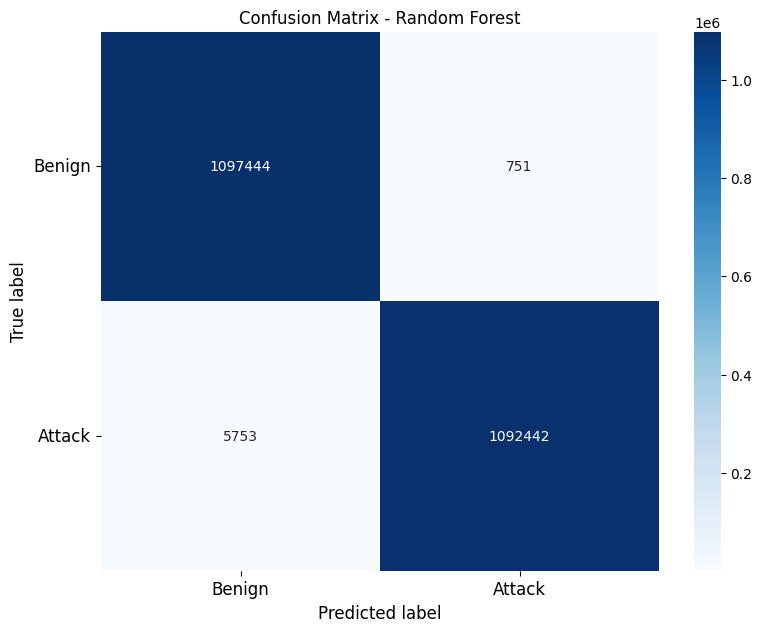

In [68]:
# Create a heatmap for the confusion matrix
plt.figure(figsize=(9, 7))  # Adjust the size as needed
sns.heatmap(aggregate_conf_matrix_binary_All_xgb, annot=True, cmap=plt.cm.Blues, fmt='d')
plt.title("Confusion Matrix - Random Forest")
x_ticks_labels = ['Benign', 'Attack']
x_ticks_positions = [0.5, 1.5]
plt.xticks(x_ticks_positions, x_ticks_labels, rotation=0, fontsize=12)
plt.yticks(x_ticks_positions, x_ticks_labels, rotation=0, fontsize=12)
plt.xlabel('Predicted label', fontsize=12)
plt.ylabel('True label', fontsize=12)
plt.show()

##### Random Forest

In [69]:
perf_all_binary_All_rf, perf_agg_binary_All_rf, perf_gs_binary_All_rf, aggregate_conf_matrix_binary_All_rf \
= train_classification(X,
                       y,
                       params = None,
                       classifier = RandomForestClassifier(random_state=1, n_jobs=-1), 
                       scoring = 'f1_macro',
                       nfold_cv = 5,
                       random_state = 1)

----------------------
Evaluation CV Fold 1:
----------------------


2) Evaluation results for fold 1:
----------------------------------

Accuracy: 0.9974, AUC Score: 0.9994, recall: 0.9974, Precision: 0.9974, F1 Score: 0.9974

Evaluation Fold 1 took 182.0 seconds

----------------------
Evaluation CV Fold 2:
----------------------


2) Evaluation results for fold 2:
----------------------------------

Accuracy: 0.9974, AUC Score: 0.9994, recall: 0.9974, Precision: 0.9974, F1 Score: 0.9974

Evaluation Fold 2 took 181.7 seconds

----------------------
Evaluation CV Fold 3:
----------------------


2) Evaluation results for fold 3:
----------------------------------

Accuracy: 0.9975, AUC Score: 0.9995, recall: 0.9975, Precision: 0.9975, F1 Score: 0.9975

Evaluation Fold 3 took 173.4 seconds

----------------------
Evaluation CV Fold 4:
----------------------


2) Evaluation results for fold 4:
----------------------------------

Accuracy: 0.9975, AUC Score: 0.9995, recall: 0.9975, Pre

In [70]:
# Export the results to csv files
np.savetxt('./results/aggregate_conf_matrix_binary_All_rf.csv', aggregate_conf_matrix_binary_All_rf, delimiter=',', fmt='%i')
perf_all_binary_All_rf.to_csv('./results/perf_all_binary_All_rf.csv', index=False)

In [71]:
pd.set_option('display.float_format', '{:.6f}'.format)
print(perf_agg_binary_All_rf)
pd.set_option('display.float_format', None) # reset to default

      Accuracy  AUC Score   Recall  Precision  F1 Score
mean  0.997400   0.999400 0.997400   0.997500  0.997400
std   0.000100   0.000000 0.000100   0.000100  0.000100


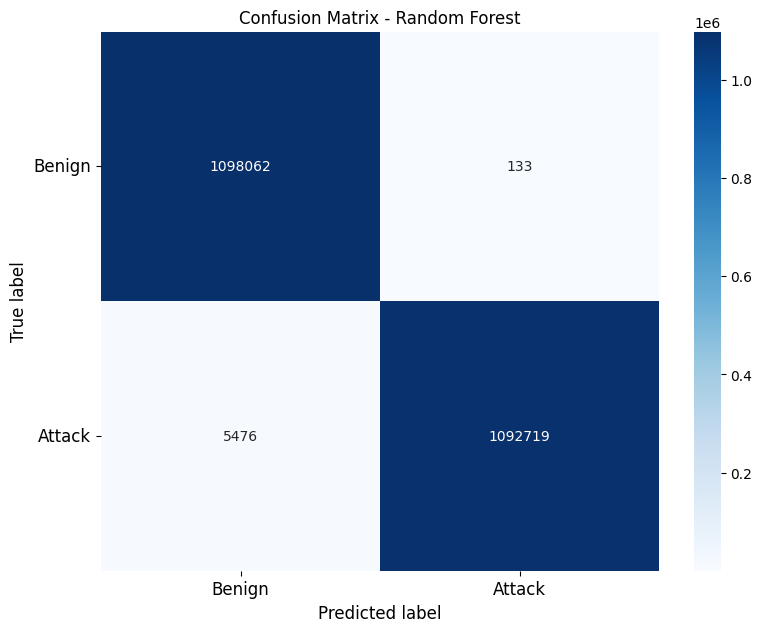

In [72]:
# Create a heatmap for the confusion matrix
plt.figure(figsize=(9, 7))  # Adjust the size as needed
sns.heatmap(aggregate_conf_matrix_binary_All_rf, annot=True, cmap=plt.cm.Blues, fmt='d')
plt.title("Confusion Matrix - Random Forest")
x_ticks_labels = ['Benign', 'Attack']
x_ticks_positions = [0.5, 1.5]
plt.xticks(x_ticks_positions, x_ticks_labels, rotation=0, fontsize=12)
plt.yticks(x_ticks_positions, x_ticks_labels, rotation=0, fontsize=12)
plt.xlabel('Predicted label', fontsize=12)
plt.ylabel('True label', fontsize=12)
plt.show()

##### Decision Tree

In [73]:
perf_all_binary_All_dt, perf_agg_binary_All_dt, perf_gs_binary_All_dt, aggregate_conf_matrix_binary_All_dt \
= train_classification(X,
                       y,
                       params = None,
                       classifier = DecisionTreeClassifier(max_depth=3, random_state=1),
                       scoring = 'f1_macro',
                       nfold_cv = 5,
                       random_state = 1)

----------------------
Evaluation CV Fold 1:
----------------------


2) Evaluation results for fold 1:
----------------------------------

Accuracy: 0.9891, AUC Score: 0.9905, recall: 0.9891, Precision: 0.9892, F1 Score: 0.9891

Evaluation Fold 1 took 20.1 seconds

----------------------
Evaluation CV Fold 2:
----------------------


2) Evaluation results for fold 2:
----------------------------------

Accuracy: 0.9890, AUC Score: 0.9904, recall: 0.9890, Precision: 0.9892, F1 Score: 0.9890

Evaluation Fold 2 took 20.5 seconds

----------------------
Evaluation CV Fold 3:
----------------------


2) Evaluation results for fold 3:
----------------------------------

Accuracy: 0.9887, AUC Score: 0.9903, recall: 0.9887, Precision: 0.9888, F1 Score: 0.9887

Evaluation Fold 3 took 19.2 seconds

----------------------
Evaluation CV Fold 4:
----------------------


2) Evaluation results for fold 4:
----------------------------------

Accuracy: 0.9889, AUC Score: 0.9905, recall: 0.9889, Precis

In [74]:
# Export the results to csv files
np.savetxt('./results/aggregate_conf_matrix_binary_All_dt.csv', aggregate_conf_matrix_binary_All_dt, delimiter=',', fmt='%i')
perf_all_binary_All_dt.to_csv('./results/perf_all_binary_All_dt.csv', index=False)

In [75]:
pd.set_option('display.float_format', '{:.6f}'.format)
print(perf_agg_binary_All_dt)
pd.set_option('display.float_format', None) # reset to default

      Accuracy  AUC Score   Recall  Precision  F1 Score
mean  0.988900   0.990400 0.988900   0.989000  0.988900
std   0.000200   0.000100 0.000200   0.000200  0.000200


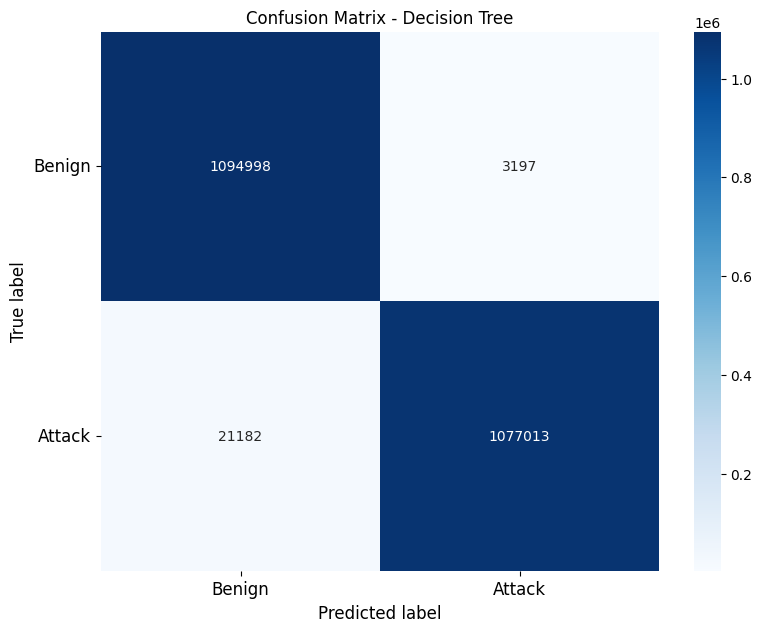

In [76]:
# Create a heatmap for the confusion matrix
plt.figure(figsize=(9, 7))  # Adjust the size as needed
sns.heatmap(aggregate_conf_matrix_binary_All_dt, annot=True, cmap=plt.cm.Blues, fmt='d')
plt.title("Confusion Matrix - Decision Tree")
x_ticks_labels = ['Benign', 'Attack']
x_ticks_positions = [0.5, 1.5]
plt.xticks(x_ticks_positions, x_ticks_labels, rotation=0, fontsize=12)
plt.yticks(x_ticks_positions, x_ticks_labels, rotation=0, fontsize=12)
plt.xlabel('Predicted label', fontsize=12)
plt.ylabel('True label', fontsize=12)
plt.show()

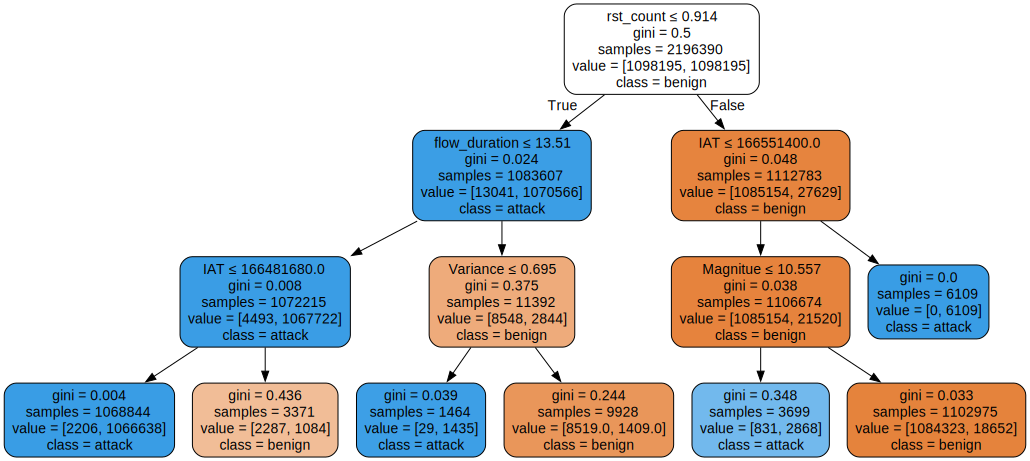

In [77]:
### Draw the decision tree based on the full dataset
# Let's fit a decision tree model
tree_All = DecisionTreeClassifier(max_depth=3, random_state=1)
_ = tree_All.fit(X, y)

dot_data = export_graphviz(tree_All, 
                           out_file = None, 
                           feature_names = X.columns,  
                           class_names = ['benign', 'attack'],  
                           filled = True, 
                           rounded = True,  
                           special_characters = True)  
tree_graph = Source(dot_data)
_ = tree_graph.render('./results/Tree_binary_All', format='png') 
tree_graph  

#### Testing on left-out attack data (No need to rerun - require large RAM)

In [21]:
### Prepare the test data
# Load the test data 
data_test = pd.read_pickle('./data/all_remaining_data.pkl')

# Remove 'ece_flag_number', 'cwr_flag_number', 'Telnet', 'SMTP' and 'DHCP'
data_test.drop(['ece_flag_number', 'cwr_flag_number', 'Telnet', 'SMTP', 'DHCP'], axis=1, inplace=True)

# Since most of the values are 0, we will convert this to a binary feature
data_test['Drate'] = data_test['Drate'].apply(lambda x: 0 if x == 0 else 1)

# Also remove since major protocol types are encoded in other columns
data_test.drop(['Protocol Type'],  axis=1, inplace=True)

# Apply log transform to the following highly skewed features: ack_count, syn_count, fin_count, urg_count and rst_count
for col in ['ack_count', 'syn_count', 'fin_count', 'urg_count', 'rst_count']:
    data_test[col] = np.log(data_test[col] + 1) # Add 1 to avoid log(0)

# Add a new column 'Attack' to indicate attack/non-attack (1/0) based on 'label' column
data_test['Attack'] = data_test['label'].apply(
    lambda x: 1 if not x.startswith('Benign') else 0)

data_test.drop("label", axis=1, inplace=True)

# Display the dimensions of the DataFrame
print("Dimensions:", data_test.shape)

unique_attack_values = data_test['Attack'].unique()
print("unique values:", unique_attack_values)

# Extract feature columns and target column
y_test = data_test['Attack']
X_test = data_test.drop(['Attack'], axis=1)
del data_test

Dimensions: (44490189, 41)
unique values: [1]


In [27]:
%%time

# Columns to be standardised
columns_to_standardise = [
    'flow_duration','Header_Length', 'Duration', 'Rate',
    'Srate', 'Tot sum','Min', 'Max', 'AVG', 'Std',
    'Tot size', 'IAT', 'Number', 'Magnitue', 'Radius',
    'Covariance', 'Variance', 'Weight'
]

# Apply StandardScaler
scaler = StandardScaler()
X[columns_to_standardise] = scaler.fit_transform(
    X[columns_to_standardise])

X_test[columns_to_standardise] = scaler.transform(
    X_test[columns_to_standardise])

### Fit the model
model = RandomForestClassifier(random_state=1, n_jobs=-1)
model.fit(X, y)

print("Training complete")

# Make predictions with the best model
y_pred = model.predict(X_test)

print("Predictions complete")

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Create a dataframe that stores the performance of rf model for each fold
performance_test = pd.DataFrame({
    "Accuracy": accuracy,
    "Recall": recall,
    "Precision": precision,
    "F1 Score": f1
})
performance_test

,Accuracy,Recall,Precision,F1 Score
0,0.995011,0.995011,1.0,0.997499


### 2) 8-Class Classification

In [80]:
# Preprocess the data
X, y = prepare_data_for_classification(balanced_df, outcome_num = 8)

Dimensions: (2196390, 41)

Mapping from encoded labels to original labels:
0 : benign
1 : brute_Force
2 : ddos
3 : dos
4 : mirai
5 : recon
6 : spoofing
7 : web_based


##### XGBoost

In [87]:
perf_all_multi8_All_xgb, perf_agg_multi8_All_xgb, perf_gs_multi8_All_xgb, aggregate_conf_matrix_multi8_All_xgb \
= train_classification(X,
                       y,
                       params = None,
                       classifier = XGBClassifier(random_state=1), # Number of classes and objective selected automatically in XGBoost library
                       scoring = 'f1_macro',
                       nfold_cv = 5,
                       random_state = 1)

----------------------
Evaluation CV Fold 1:
----------------------


2) Evaluation results for fold 1:
----------------------------------

Accuracy: 0.9963, AUC Score: 0.9964, recall: 0.7013, Precision: 0.8762, F1 Score: 0.7472

Evaluation Fold 1 took 104.9 seconds

----------------------
Evaluation CV Fold 2:
----------------------


2) Evaluation results for fold 2:
----------------------------------

Accuracy: 0.9963, AUC Score: 0.9961, recall: 0.7003, Precision: 0.8769, F1 Score: 0.7445

Evaluation Fold 2 took 102.9 seconds

----------------------
Evaluation CV Fold 3:
----------------------


2) Evaluation results for fold 3:
----------------------------------

Accuracy: 0.9965, AUC Score: 0.9966, recall: 0.7054, Precision: 0.9292, F1 Score: 0.7520

Evaluation Fold 3 took 104.8 seconds

----------------------
Evaluation CV Fold 4:
----------------------


2) Evaluation results for fold 4:
----------------------------------

Accuracy: 0.9967, AUC Score: 0.9956, recall: 0.7145, Pre

In [88]:
# Export the results to csv files
np.savetxt('./results/aggregate_conf_matrix_multi8_All_xgb.csv', aggregate_conf_matrix_multi8_All_xgb, delimiter=',', fmt='%i')
perf_all_multi8_All_xgb.to_csv('./results/perf_all_multi8_All_xgb.csv', index=False)

In [89]:
pd.set_option('display.float_format', '{:.6f}'.format)
print(perf_agg_multi8_All_xgb)
pd.set_option('display.float_format', None) # reset to default

      Accuracy  AUC Score   Recall  Precision  F1 Score
mean  0.996500   0.996400 0.706700   0.902700  0.752900
std   0.000200   0.000600 0.006400   0.024500  0.007400


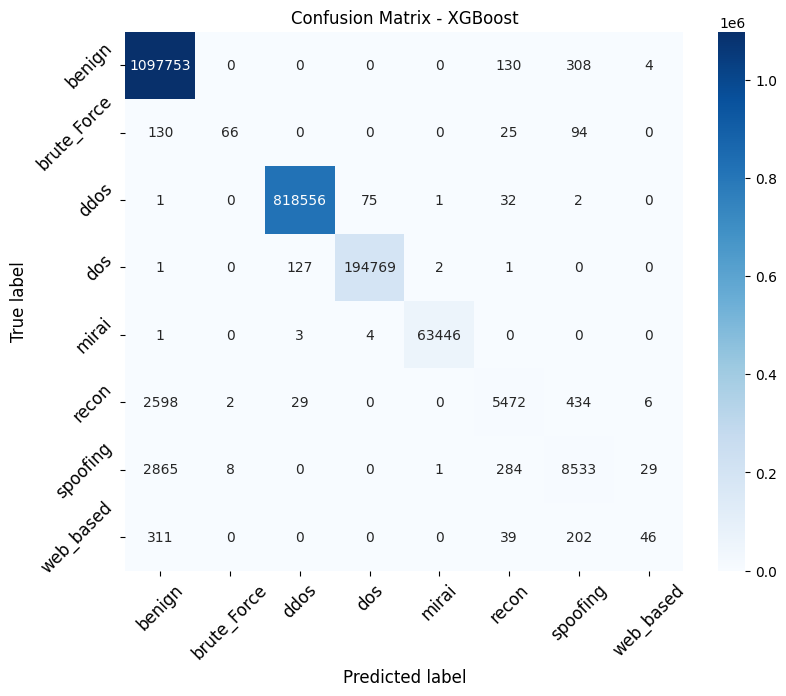

In [90]:
# Create a heatmap for the confusion matrix
plt.figure(figsize=(9, 7))  # Adjust the size as needed
sns.heatmap(aggregate_conf_matrix_multi8_All_xgb, annot=True, cmap=plt.cm.Blues, fmt='d')
plt.title("Confusion Matrix - XGBoost")

# Specify the class labels for both axes
class_labels = ["benign", "brute_Force", "ddos", "dos", "mirai", "recon", "spoofing", "web_based"]

# Set ticks and labels for both axes
plt.xticks(np.arange(len(class_labels)) + 0.5, class_labels, rotation=45, fontsize=12)
plt.yticks(np.arange(len(class_labels)) + 0.5, class_labels, rotation=45, fontsize=12)
plt.xlabel('Predicted label', fontsize=12)
plt.ylabel('True label', fontsize=12)

plt.show()

##### Random Forest

In [103]:
perf_all_multi8_All_rf, perf_agg_multi8_All_rf, perf_gs_multi8_All_rf, aggregate_conf_matrix_multi8_All_rf \
= train_classification(X,
                       y,
                       params = None,
                       classifier = RandomForestClassifier(random_state=1, n_jobs=-1),
                       scoring = 'f1_macro',
                       nfold_cv = 5,
                       random_state = 1)

----------------------
Evaluation CV Fold 1:
----------------------


2) Evaluation results for fold 1:
----------------------------------

Accuracy: 0.9969, AUC Score: 0.9581, recall: 0.7418, Precision: 0.9890, F1 Score: 0.8031

Evaluation Fold 1 took 195.8 seconds

----------------------
Evaluation CV Fold 2:
----------------------


2) Evaluation results for fold 2:
----------------------------------

Accuracy: 0.9969, AUC Score: 0.9606, recall: 0.7483, Precision: 0.9881, F1 Score: 0.8105

Evaluation Fold 2 took 195.1 seconds

----------------------
Evaluation CV Fold 3:
----------------------


2) Evaluation results for fold 3:
----------------------------------

Accuracy: 0.9970, AUC Score: 0.9638, recall: 0.7637, Precision: 0.9896, F1 Score: 0.8274

Evaluation Fold 3 took 197.5 seconds

----------------------
Evaluation CV Fold 4:
----------------------


2) Evaluation results for fold 4:
----------------------------------

Accuracy: 0.9970, AUC Score: 0.9652, recall: 0.7591, Pre

In [104]:
# Export the results to csv files
np.savetxt('./results/aggregate_conf_matrix_multi8_All_rf.csv', aggregate_conf_matrix_multi8_All_rf, delimiter=',', fmt='%i')
perf_all_multi8_All_rf.to_csv('./results/perf_all_multi8_All_rf.csv', index=False)

In [105]:
pd.set_option('display.float_format', '{:.6f}'.format)
print(perf_agg_multi8_All_rf)
pd.set_option('display.float_format', None) # reset to default

      Accuracy  AUC Score   Recall  Precision  F1 Score
mean  0.997000   0.962600 0.753900   0.985800  0.816000
std   0.000100   0.003200 0.008800   0.004400  0.009500


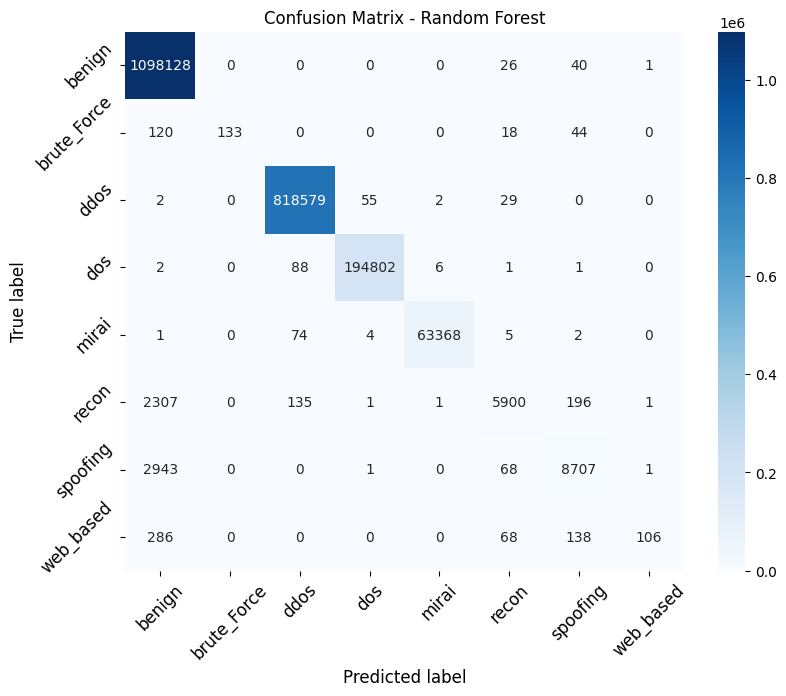

In [106]:
# Create a heatmap for the confusion matrix
plt.figure(figsize=(9, 7))  # Adjust the size as needed
sns.heatmap(aggregate_conf_matrix_multi8_All_rf, annot=True, cmap=plt.cm.Blues, fmt='d')
plt.title("Confusion Matrix - Random Forest")

# Specify the class labels for both axes
class_labels = ["benign", "brute_Force", "ddos", "dos", "mirai", "recon", "spoofing", "web_based"]

# Set ticks and labels for both axes
plt.xticks(np.arange(len(class_labels)) + 0.5, class_labels, rotation=45, fontsize=12)
plt.yticks(np.arange(len(class_labels)) + 0.5, class_labels, rotation=45, fontsize=12)
plt.xlabel('Predicted label', fontsize=12)
plt.ylabel('True label', fontsize=12)

plt.show()

##### Decision Tree

In [99]:
perf_all_multi8_All_dt, perf_agg_multi8_All_dt, perf_gs_multi8_All_dt, aggregate_conf_matrix_multi8_All_dt \
= train_classification(X,
                       y,
                       params = None,
                       classifier = DecisionTreeClassifier(max_depth=3, random_state=1),
                       scoring = 'f1_macro',
                       nfold_cv = 5,
                       random_state = 1)

----------------------
Evaluation CV Fold 1:
----------------------


2) Evaluation results for fold 1:
----------------------------------

Accuracy: 0.9839, AUC Score: 0.9216, recall: 0.5445, Precision: 0.5797, F1 Score: 0.5543

Evaluation Fold 1 took 21.0 seconds

----------------------
Evaluation CV Fold 2:
----------------------


2) Evaluation results for fold 2:
----------------------------------

Accuracy: 0.9839, AUC Score: 0.9192, recall: 0.5429, Precision: 0.5777, F1 Score: 0.5527

Evaluation Fold 2 took 21.0 seconds

----------------------
Evaluation CV Fold 3:
----------------------


2) Evaluation results for fold 3:
----------------------------------

Accuracy: 0.9842, AUC Score: 0.9259, recall: 0.5441, Precision: 0.5809, F1 Score: 0.5545

Evaluation Fold 3 took 21.6 seconds

----------------------
Evaluation CV Fold 4:
----------------------


2) Evaluation results for fold 4:
----------------------------------

Accuracy: 0.9838, AUC Score: 0.9209, recall: 0.5431, Precis

In [100]:
# Export the results to csv files
np.savetxt('./results/aggregate_conf_matrix_multi8_All_dt.csv', aggregate_conf_matrix_multi8_All_dt, delimiter=',', fmt='%i')
perf_all_multi8_All_dt.to_csv('./results/perf_all_multi8_All_dt.csv', index=False)

In [101]:
pd.set_option('display.float_format', '{:.6f}'.format)
print(perf_agg_multi8_All_dt)
pd.set_option('display.float_format', None) # reset to default

      Accuracy  AUC Score   Recall  Precision  F1 Score
mean  0.983900   0.922000 0.543800   0.579100  0.553700
std   0.000100   0.002500 0.000800   0.001300  0.001000


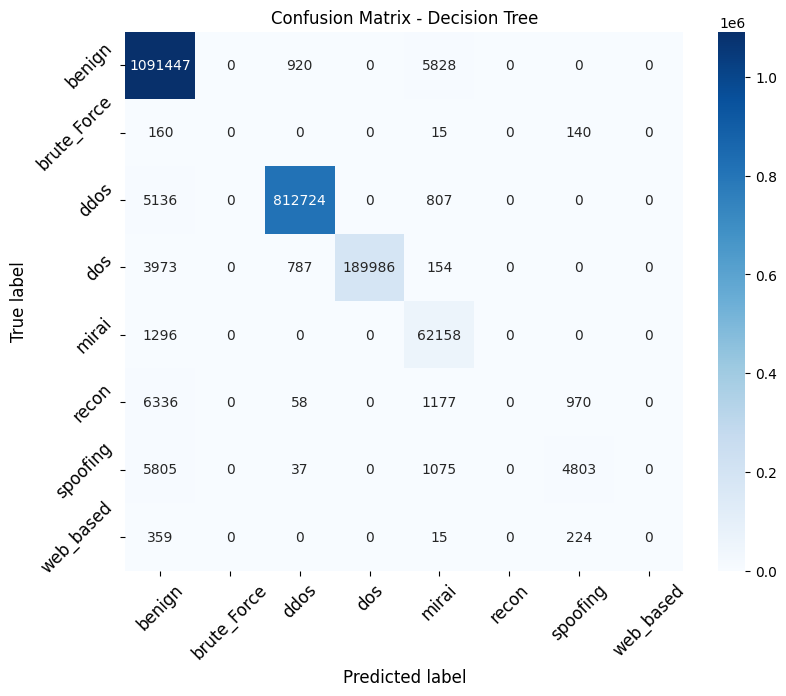

In [102]:
# Create a heatmap for the confusion matrix
plt.figure(figsize=(9, 7))  # Adjust the size as needed
sns.heatmap(aggregate_conf_matrix_multi8_All_dt, annot=True, cmap=plt.cm.Blues, fmt='d')
plt.title("Confusion Matrix - Decision Tree")

# Specify the class labels for both axes
class_labels = ["benign", "brute_Force", "ddos", "dos", "mirai", "recon", "spoofing", "web_based"]

# Set ticks and labels for both axes
plt.xticks(np.arange(len(class_labels)) + 0.5, class_labels, rotation=45, fontsize=12)
plt.yticks(np.arange(len(class_labels)) + 0.5, class_labels, rotation=45, fontsize=12)
plt.xlabel('Predicted label', fontsize=12)
plt.ylabel('True label', fontsize=12)

plt.show()

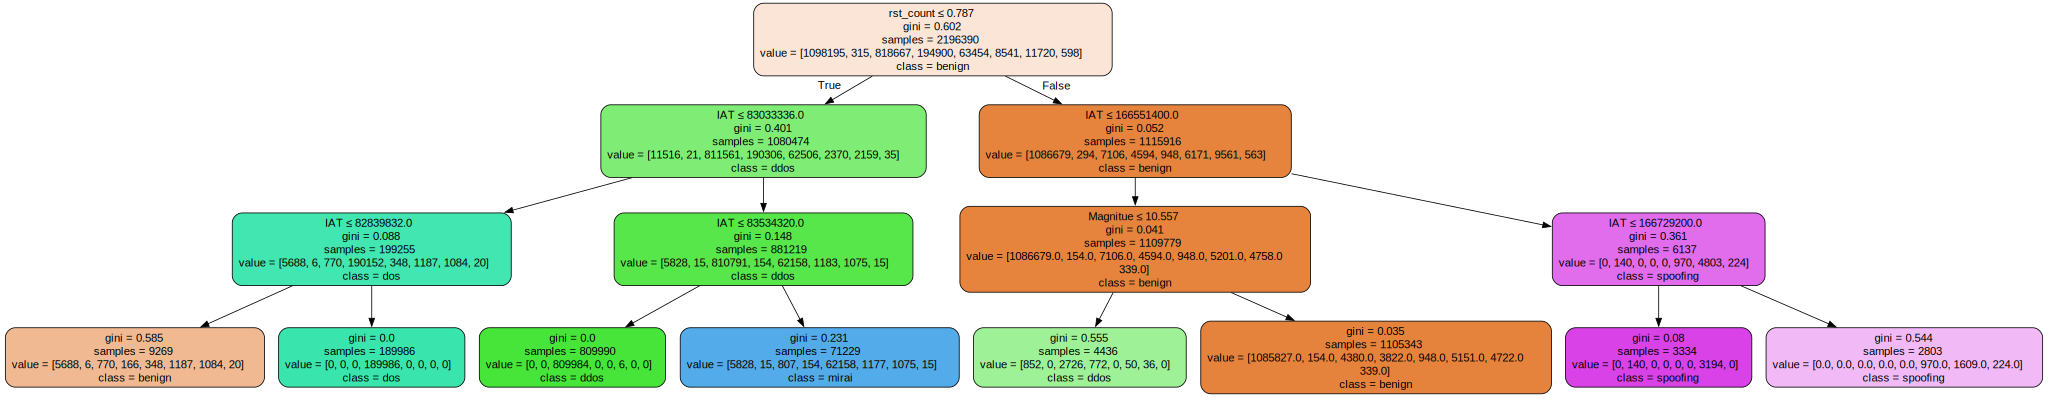

In [107]:
### Draw the decision tree based on the full dataset
# Let's fit a decision tree model
tree_multi8 = DecisionTreeClassifier(max_depth=3, random_state=1)
_ = tree_multi8.fit(X, y)


dot_data = export_graphviz(tree_multi8, 
                           out_file = None, 
                           feature_names = X.columns,  
                           class_names = ["benign", "brute_Force", "ddos", "dos", "mirai", "recon", "spoofing", "web_based"],  
                           filled = True, 
                           rounded = True,  
                           special_characters = True)  
tree_graph = Source(dot_data)
_ = tree_graph.render('./results/Tree_binary_multi8', format='png') 
tree_graph  

### 3) 34-Class Training

In [139]:
# Preprocess the data
X, y = prepare_data_for_classification(balanced_df, outcome_num = 34)

Dimensions: (2196390, 41)

Mapping from encoded labels to original labels:
0 : benign
1 : BrowserHijacking
2 : CommandInjection
3 : DDoS-ACK_Fragmentation
4 : DDoS-HTTP_Flood
5 : DDoS-ICMP_Flood
6 : DDoS-ICMP_Fragmentation
7 : DDoS-PSHACK_Flood
8 : DDoS-RSTFINFlood
9 : DDoS-SYN_Flood
10 : DDoS-SlowLoris
11 : DDoS-SynonymousIP_Flood
12 : DDoS-TCP_Flood
13 : DDoS-UDP_Flood
14 : DDoS-UDP_Fragmentation
15 : DNS_Spoofing
16 : DictionaryBruteForce
17 : DoS-HTTP_Flood
18 : DoS-SYN_Flood
19 : DoS-TCP_Flood
20 : DoS-UDP_Flood
21 : MITM-ArpSpoofing
22 : Mirai-greeth_flood
23 : Mirai-greip_flood
24 : Mirai-udpplain
25 : Recon-HostDiscovery
26 : Recon-OSScan
27 : Recon-PingSweep
28 : Recon-PortScan
29 : SqlInjection
30 : Uploading_Attack
31 : VulnerabilityScan
32 : XSS
33 : Backdoor_Malware


##### XGBoost

In [140]:
perf_all_multi34_All_xgb, perf_agg_multi34_All_xgb, perf_gs_multi34_All_xgb, aggregate_conf_matrix_multi34_All_xgb \
= train_classification(X,
                       y,
                       params = None,
                       classifier = XGBClassifier(random_state=1), # Number of classes and objective selected automatically in XGBoost library
                       scoring = 'f1_macro',
                       nfold_cv = 5,
                       random_state = 1)

----------------------
Evaluation CV Fold 1:
----------------------


2) Evaluation results for fold 1:
----------------------------------

Accuracy: 0.9953, AUC Score: 0.9973, recall: 0.7089, Precision: 0.8401, F1 Score: 0.7343

Evaluation Fold 1 took 569.9 seconds

----------------------
Evaluation CV Fold 2:
----------------------


2) Evaluation results for fold 2:
----------------------------------

Accuracy: 0.9954, AUC Score: 0.9964, recall: 0.7039, Precision: 0.7776, F1 Score: 0.7232

Evaluation Fold 2 took 486.0 seconds

----------------------
Evaluation CV Fold 3:
----------------------


2) Evaluation results for fold 3:
----------------------------------

Accuracy: 0.9953, AUC Score: 0.9964, recall: 0.7087, Precision: 0.8067, F1 Score: 0.7281

Evaluation Fold 3 took 463.9 seconds

----------------------
Evaluation CV Fold 4:
----------------------


2) Evaluation results for fold 4:
----------------------------------

Accuracy: 0.9953, AUC Score: 0.9971, recall: 0.7113, Pre

In [141]:
# Export the results to csv files
np.savetxt('./results/aggregate_conf_matrix_multi34_All_xgb.csv', aggregate_conf_matrix_multi34_All_xgb, delimiter=',', fmt='%i')
perf_all_multi34_All_xgb.to_csv('./results/perf_all_multi34_All_xgb.csv', index=False)

In [142]:
pd.set_option('display.float_format', '{:.6f}'.format)
print(perf_agg_multi34_All_xgb)
pd.set_option('display.float_format', None) # reset to default

      Accuracy  AUC Score   Recall  Precision  F1 Score
mean  0.995300   0.997000 0.708200   0.811100  0.729600
std   0.000000   0.000600 0.002700   0.022700  0.004500


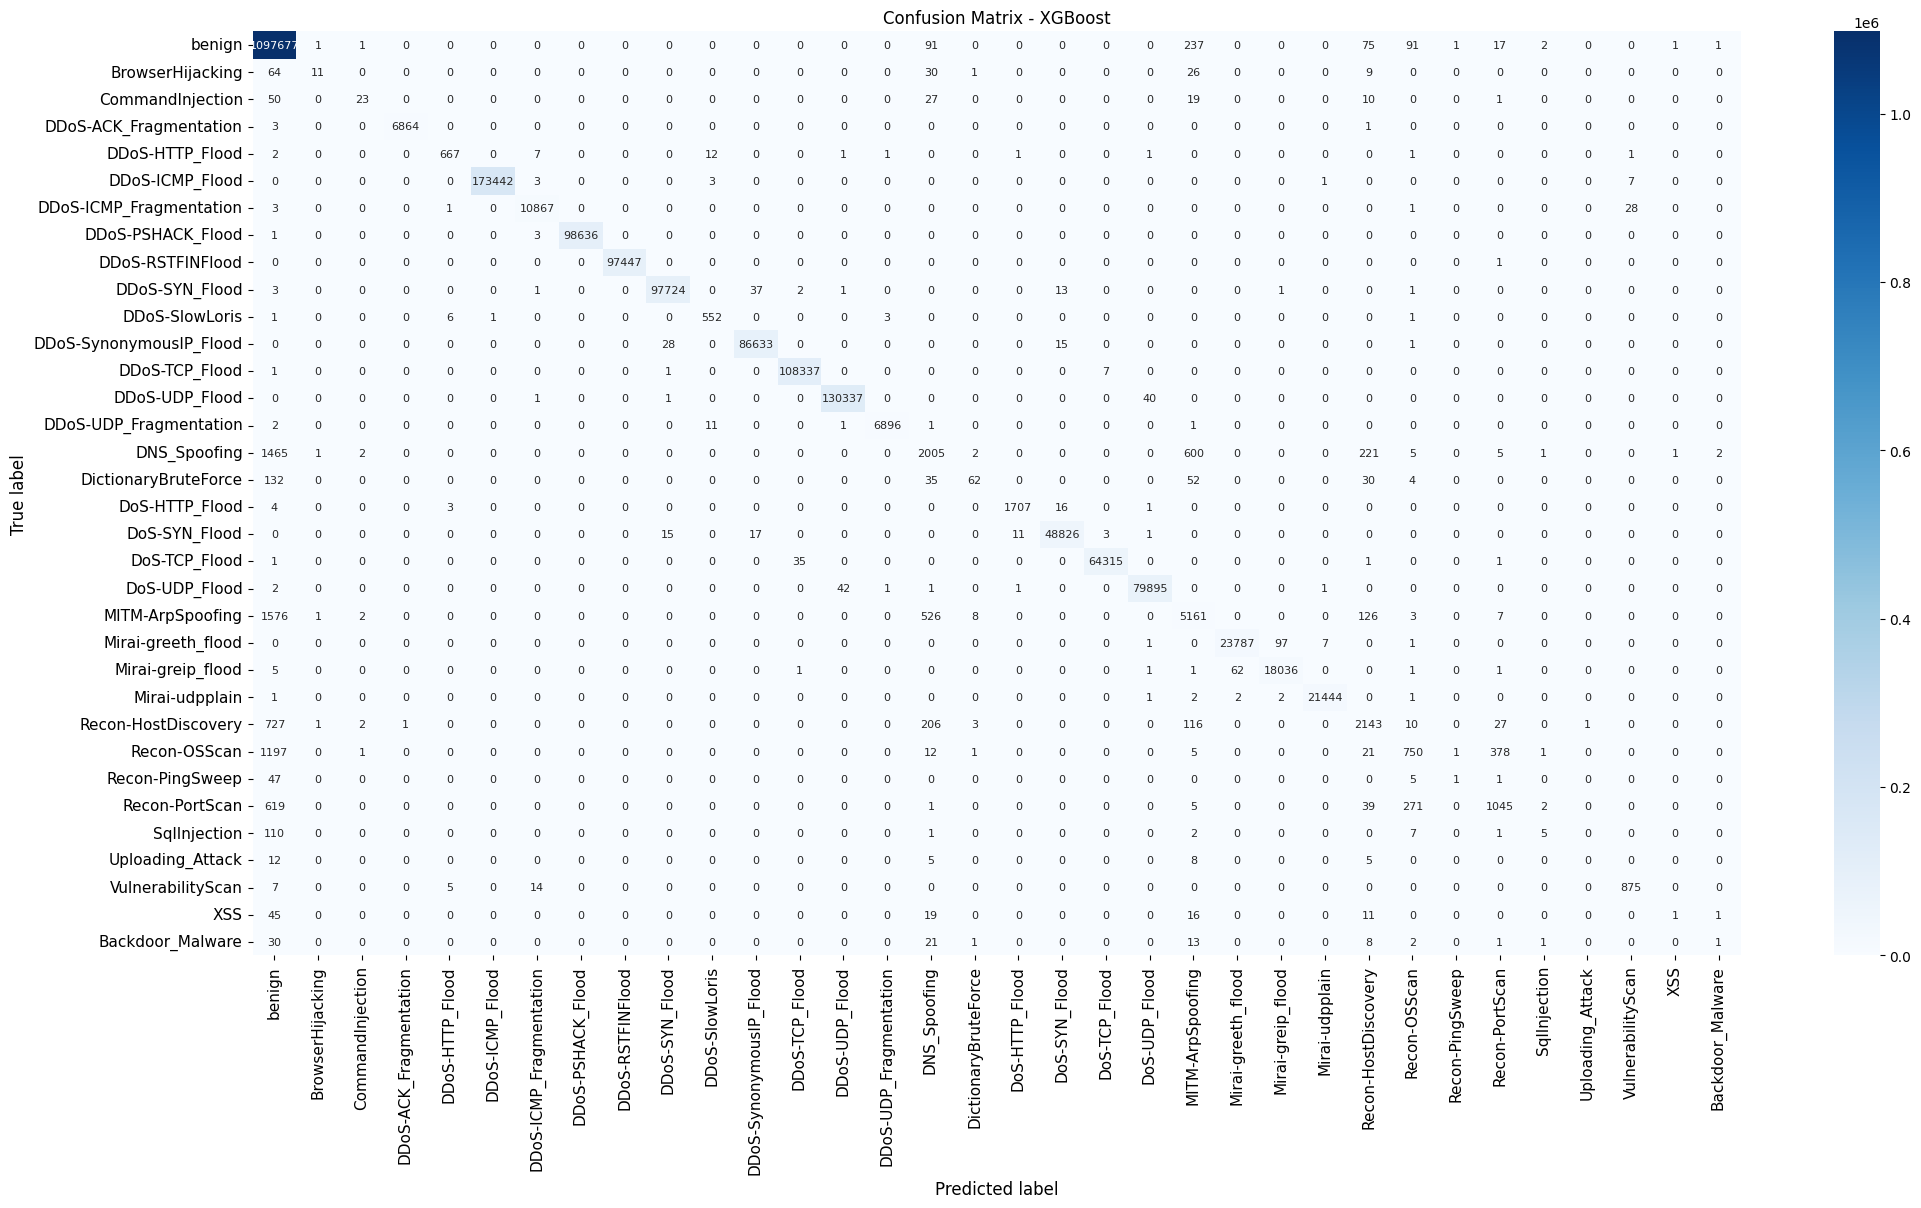

In [160]:
# Create a heatmap for the confusion matrix
plt.figure(figsize=(24, 12))
sns.heatmap(aggregate_conf_matrix_multi34_All_xgb, annot=True, cmap=plt.cm.Blues, fmt='d', annot_kws={'size': 8})
plt.title("Confusion Matrix - XGBoost")

# Specify the class labels for both axes
class_labels = ["benign", "BrowserHijacking", "CommandInjection", "DDoS-ACK_Fragmentation",
                "DDoS-HTTP_Flood", "DDoS-ICMP_Flood", "DDoS-ICMP_Fragmentation", "DDoS-PSHACK_Flood",
                "DDoS-RSTFINFlood", "DDoS-SYN_Flood", "DDoS-SlowLoris", "DDoS-SynonymousIP_Flood", "DDoS-TCP_Flood",
                "DDoS-UDP_Flood", "DDoS-UDP_Fragmentation", "DNS_Spoofing", "DictionaryBruteForce", "DoS-HTTP_Flood", 
                "DoS-SYN_Flood", "DoS-TCP_Flood", "DoS-UDP_Flood", "MITM-ArpSpoofing", "Mirai-greeth_flood", 
                "Mirai-greip_flood", "Mirai-udpplain", "Recon-HostDiscovery", "Recon-OSScan", "Recon-PingSweep", 
                "Recon-PortScan", "SqlInjection", "Uploading_Attack", "VulnerabilityScan", "XSS", "Backdoor_Malware"]

# Set ticks and labels for both axes
plt.xticks(np.arange(len(class_labels)) + 0.5, class_labels, rotation=90, fontsize=11)
plt.yticks(np.arange(len(class_labels)) + 0.5, class_labels, rotation=0, fontsize=11)
plt.xlabel('Predicted label', fontsize=12)
plt.ylabel('True label', fontsize=12)

plt.show()

##### Random Forest

In [166]:
perf_all_multi34_All_rf, perf_agg_multi34_All_rf, perf_gs_multi34_All_rf, aggregate_conf_matrix_multi34_All_rf \
= train_classification(X,
                       y,
                       params = None,
                       classifier = RandomForestClassifier(random_state=1, n_jobs=-1),
                       scoring = 'f1_macro',
                       nfold_cv = 5,
                       random_state = 1)

----------------------
Evaluation CV Fold 1:
----------------------


2) Evaluation results for fold 1:
----------------------------------

Accuracy: 0.9961, AUC Score: 0.9604, recall: 0.7275, Precision: 0.8850, F1 Score: 0.7552

Evaluation Fold 1 took 224.4 seconds

----------------------
Evaluation CV Fold 2:
----------------------


2) Evaluation results for fold 2:
----------------------------------

Accuracy: 0.9962, AUC Score: 0.9500, recall: 0.7266, Precision: 0.8267, F1 Score: 0.7499

Evaluation Fold 2 took 226.7 seconds

----------------------
Evaluation CV Fold 3:
----------------------


2) Evaluation results for fold 3:
----------------------------------

Accuracy: 0.9963, AUC Score: 0.9517, recall: 0.7269, Precision: 0.8456, F1 Score: 0.7486

Evaluation Fold 3 took 234.0 seconds

----------------------
Evaluation CV Fold 4:
----------------------


2) Evaluation results for fold 4:
----------------------------------

Accuracy: 0.9962, AUC Score: 0.9502, recall: 0.7322, Pre

In [167]:
# Export the results to csv files
np.savetxt('./results/aggregate_conf_matrix_multi34_All_rf.csv', aggregate_conf_matrix_multi34_All_rf, delimiter=',', fmt='%i')
perf_all_multi34_All_rf.to_csv('./results/perf_all_multi34_All_rf.csv', index=False)

In [168]:
pd.set_option('display.float_format', '{:.6f}'.format)
print(perf_agg_multi34_All_rf)
pd.set_option('display.float_format', None) # reset to default

      Accuracy  AUC Score   Recall  Precision  F1 Score
mean  0.996200   0.953400 0.727600   0.846800  0.751700
std   0.000100   0.004300 0.002800   0.025400  0.003400


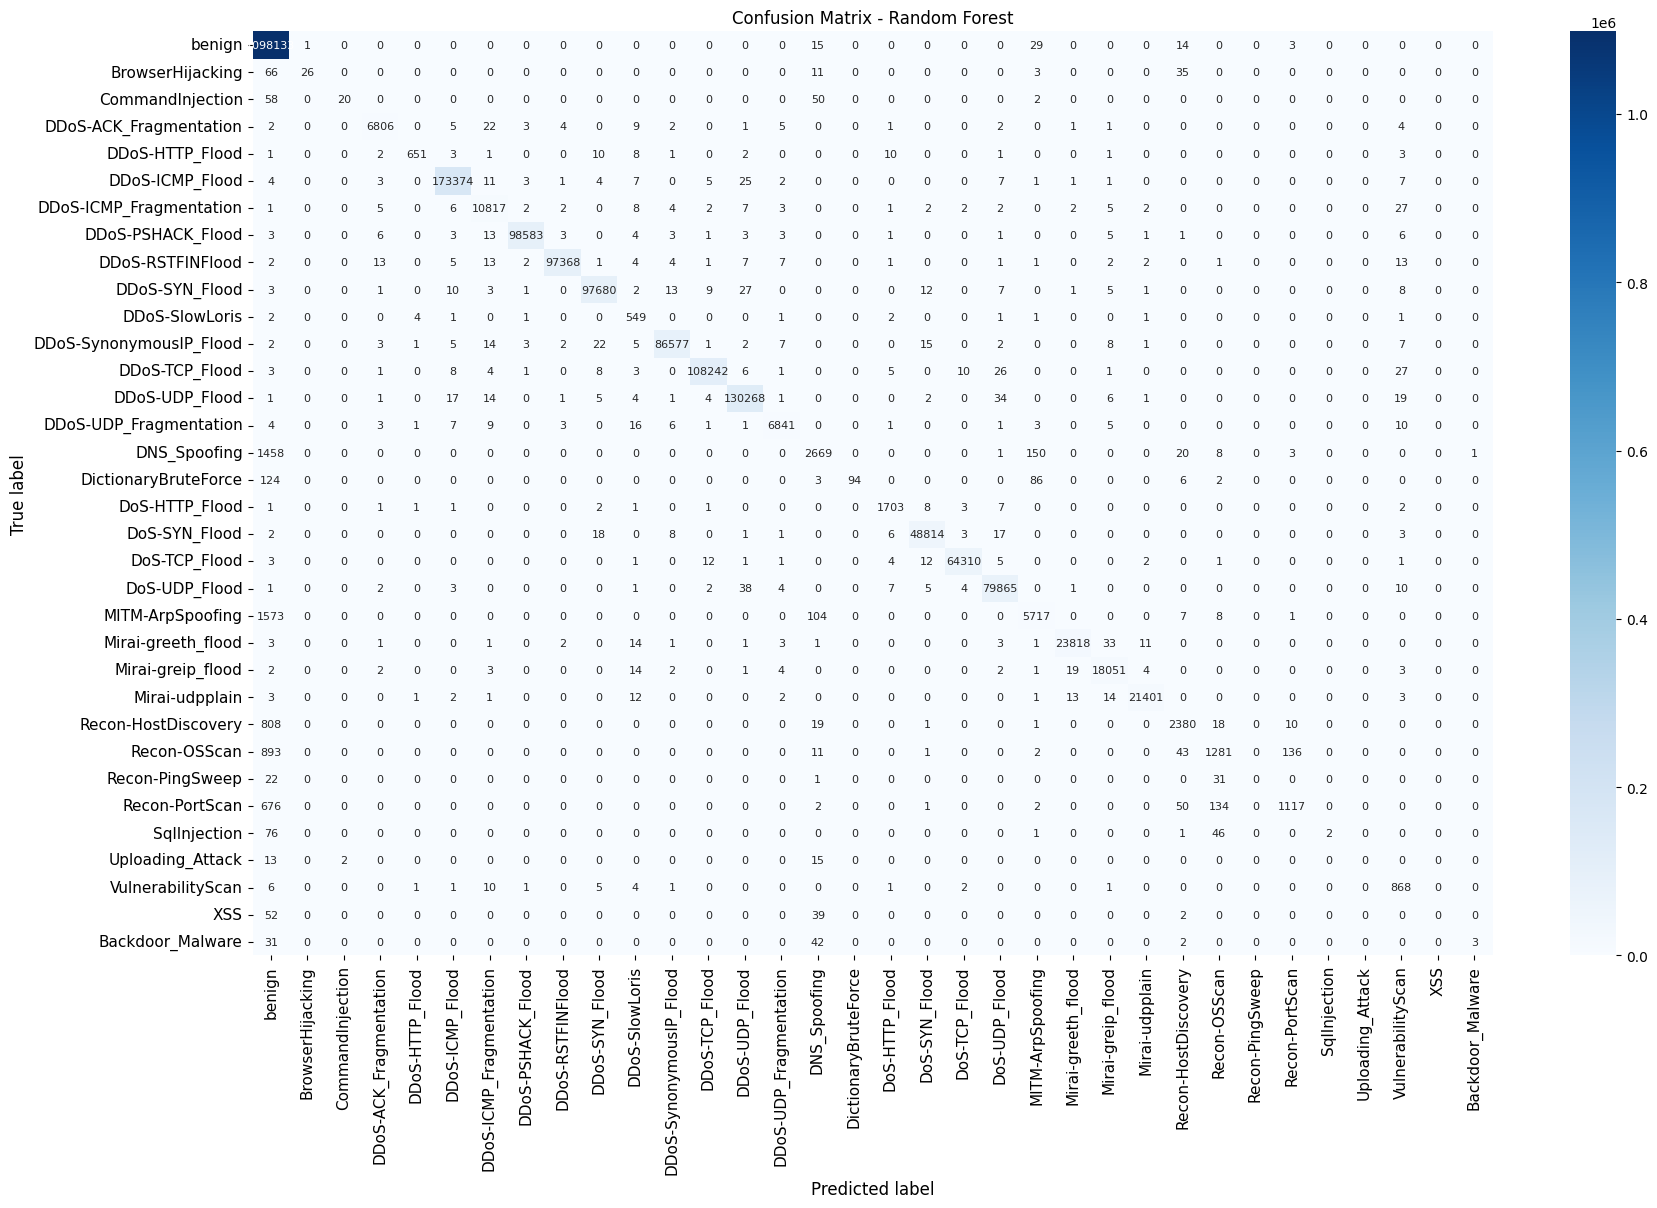

In [169]:
# Create a heatmap for the confusion matrix
plt.figure(figsize=(20, 12))
sns.heatmap(aggregate_conf_matrix_multi34_All_rf, annot=True, cmap=plt.cm.Blues, fmt='d', annot_kws={'size': 8})
plt.title("Confusion Matrix - Random Forest")

# Specify the class labels for both axes
class_labels = ["benign", "BrowserHijacking", "CommandInjection", "DDoS-ACK_Fragmentation",
                "DDoS-HTTP_Flood", "DDoS-ICMP_Flood", "DDoS-ICMP_Fragmentation", "DDoS-PSHACK_Flood",
                "DDoS-RSTFINFlood", "DDoS-SYN_Flood", "DDoS-SlowLoris", "DDoS-SynonymousIP_Flood", "DDoS-TCP_Flood",
                "DDoS-UDP_Flood", "DDoS-UDP_Fragmentation", "DNS_Spoofing", "DictionaryBruteForce", "DoS-HTTP_Flood", 
                "DoS-SYN_Flood", "DoS-TCP_Flood", "DoS-UDP_Flood", "MITM-ArpSpoofing", "Mirai-greeth_flood", 
                "Mirai-greip_flood", "Mirai-udpplain", "Recon-HostDiscovery", "Recon-OSScan", "Recon-PingSweep", 
                "Recon-PortScan", "SqlInjection", "Uploading_Attack", "VulnerabilityScan", "XSS", "Backdoor_Malware"]

# Set ticks and labels for both axes
plt.xticks(np.arange(len(class_labels)) + 0.5, class_labels, rotation=90, fontsize=11)
plt.yticks(np.arange(len(class_labels)) + 0.5, class_labels, rotation=0, fontsize=11)
plt.xlabel('Predicted label', fontsize=12)
plt.ylabel('True label', fontsize=12)

plt.show()

##### Decision Tree

In [154]:
perf_all_multi34_All_dt, perf_agg_multi34_All_dt, perf_gs_multi34_All_dt, aggregate_conf_matrix_multi34_All_dt \
= train_classification(X,
                       y,
                       params = None,
                       classifier = DecisionTreeClassifier(max_depth=3, random_state=1),
                       scoring = 'f1_macro',
                       nfold_cv = 5,
                       random_state = 1)

----------------------
Evaluation CV Fold 1:
----------------------


2) Evaluation results for fold 1:
----------------------------------

Accuracy: 0.6854, AUC Score: 0.8204, recall: 0.1415, Precision: 0.1701, F1 Score: 0.1245

Evaluation Fold 1 took 27.2 seconds

----------------------
Evaluation CV Fold 2:
----------------------


2) Evaluation results for fold 2:
----------------------------------

Accuracy: 0.6853, AUC Score: 0.8094, recall: 0.1426, Precision: 0.1691, F1 Score: 0.1255

Evaluation Fold 2 took 26.7 seconds

----------------------
Evaluation CV Fold 3:
----------------------


2) Evaluation results for fold 3:
----------------------------------

Accuracy: 0.6855, AUC Score: 0.8201, recall: 0.1430, Precision: 0.1672, F1 Score: 0.1256

Evaluation Fold 3 took 26.4 seconds

----------------------
Evaluation CV Fold 4:
----------------------


2) Evaluation results for fold 4:
----------------------------------

Accuracy: 0.6843, AUC Score: 0.8103, recall: 0.1424, Precis

In [155]:
# Export the results to csv files
np.savetxt('./results/aggregate_conf_matrix_multi34_All_dt.csv', aggregate_conf_matrix_multi34_All_dt, delimiter=',', fmt='%i')
perf_all_multi34_All_dt.to_csv('./results/perf_all_multi34_All_dt.csv', index=False)

In [156]:
pd.set_option('display.float_format', '{:.6f}'.format)
print(perf_agg_multi34_All_dt)
pd.set_option('display.float_format', None) # reset to default

      Accuracy  AUC Score   Recall  Precision  F1 Score
mean  0.685200   0.814100 0.142300   0.168600  0.125200
std   0.000500   0.005600 0.000600   0.001100  0.000400


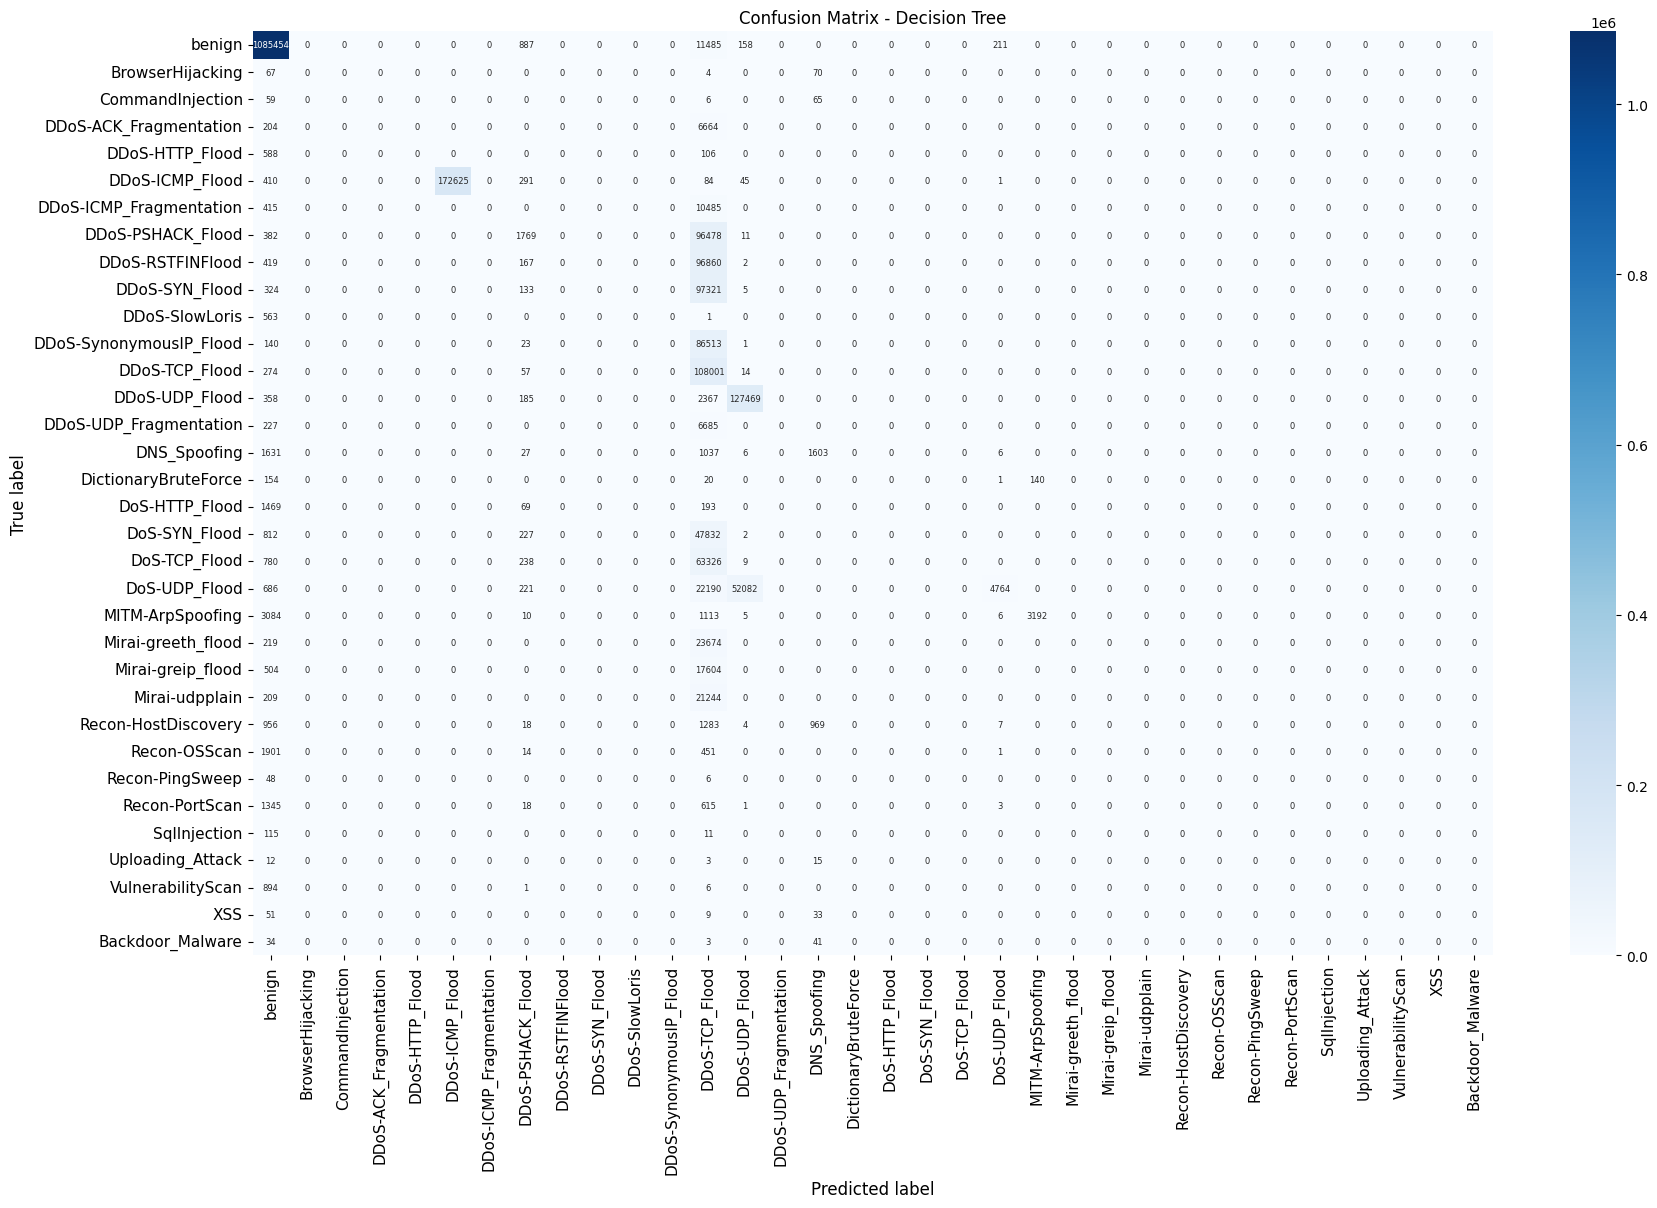

In [165]:
# Create a heatmap for the confusion matrix
plt.figure(figsize=(20, 12))
sns.heatmap(aggregate_conf_matrix_multi34_All_dt, annot=True, cmap=plt.cm.Blues, fmt='d', annot_kws={'size': 6})
plt.title("Confusion Matrix - Decision Tree")

# Specify the class labels for both axes
class_labels = ["benign", "BrowserHijacking", "CommandInjection", "DDoS-ACK_Fragmentation",
                "DDoS-HTTP_Flood", "DDoS-ICMP_Flood", "DDoS-ICMP_Fragmentation", "DDoS-PSHACK_Flood",
                "DDoS-RSTFINFlood", "DDoS-SYN_Flood", "DDoS-SlowLoris", "DDoS-SynonymousIP_Flood", "DDoS-TCP_Flood",
                "DDoS-UDP_Flood", "DDoS-UDP_Fragmentation", "DNS_Spoofing", "DictionaryBruteForce", "DoS-HTTP_Flood", 
                "DoS-SYN_Flood", "DoS-TCP_Flood", "DoS-UDP_Flood", "MITM-ArpSpoofing", "Mirai-greeth_flood", 
                "Mirai-greip_flood", "Mirai-udpplain", "Recon-HostDiscovery", "Recon-OSScan", "Recon-PingSweep", 
                "Recon-PortScan", "SqlInjection", "Uploading_Attack", "VulnerabilityScan", "XSS", "Backdoor_Malware"]

# Set ticks and labels for both axes
plt.xticks(np.arange(len(class_labels)) + 0.5, class_labels, rotation=90, fontsize=11)
plt.yticks(np.arange(len(class_labels)) + 0.5, class_labels, rotation=0, fontsize=11)
plt.xlabel('Predicted label', fontsize=12)
plt.ylabel('True label', fontsize=12)

plt.show()

# III.Testing batch size effect on F1-score for binary classification

In [ ]:
# Load balanced data
balanced_df = pd.read_csv('./data/max_balanced_data.csv')

In [ ]:
# Apply cleaning steps to the balanced data as before
balanced_df = clean_data(balanced_df)

training (Scroll donw on the output)

Dimensions: (250000, 41)

Mapping from encoded labels to original labels:
0 : benign
1 : attack
----------------------
Evaluation CV Fold 1:
----------------------


2) Evaluation results for fold 1:
----------------------------------

Accuracy: 0.9904, AUC Score: 0.9985, recall: 0.9904, Precision: 0.9905, F1 Score: 0.9904

Evaluation Fold 1 took 62.5 seconds

----------------------
Evaluation CV Fold 2:
----------------------


2) Evaluation results for fold 2:
----------------------------------

Accuracy: 0.9912, AUC Score: 0.9987, recall: 0.9912, Precision: 0.9912, F1 Score: 0.9912

Evaluation Fold 2 took 63.0 seconds

----------------------
Evaluation CV Fold 3:
----------------------


2) Evaluation results for fold 3:
----------------------------------

Accuracy: 0.9916, AUC Score: 0.9985, recall: 0.9916, Precision: 0.9916, F1 Score: 0.9916

Evaluation Fold 3 took 64.6 seconds

----------------------
Evaluation CV Fold 4:
----------------------


2) Evaluation results for fold 4:

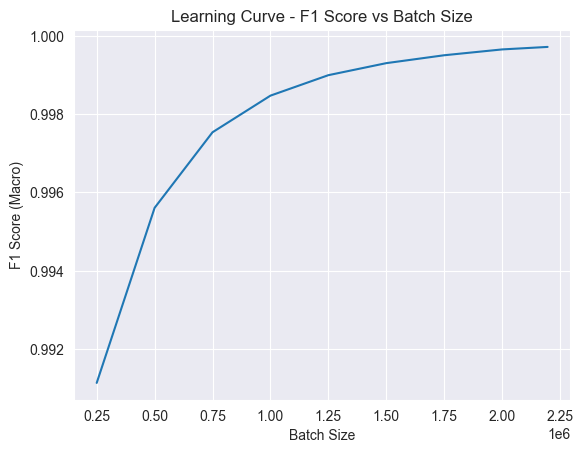

In [ ]:
# Define the list of batch sizes
batch_sizes = [250000, 500000, 750000,1000000,1250000,1500000,1750000,2000000, 2196311]

# Initialize lists to store f1_macro scores for each batch size
f1_scores = []

# Iterate over each batch size
for batch_size in batch_sizes:
    sampled_data=learn_curve_data_prep(balanced_df, batch_size)
    # Preprocess the data
    X, y = prepare_data_for_classification(sampled_data, outcome_num=2)

    # Train the model and get the f1_macro score to observe learning curve as training size increases
    perf_all_binary_rf, perf_agg_binary_rf, perf_gs_binary_rf, aggregate_conf_matrix_rf \
        = train_classification(X,
                               y,
                               classifier=RandomForestClassifier(random_state=1),
                               scoring='f1_scores',
                               nfold_cv=5,
                               random_state=1)

    # Append the f1_macro score to the list
    f1_scores.append(perf_all_binary_rf['F1 Score'])

# Convert the list of F1 scores to a numpy array
f1_scores_array = np.array(f1_scores)

# Plot learning curve
average_f1_scores = np.mean(f1_scores_array, axis=1)

plt.plot(batch_sizes, average_f1_scores)
plt.xlabel("Batch Size")
plt.ylabel("F1 Score (Macro)")
plt.title("Learning Curve - F1 Score vs Batch Size")
plt.show()

#### Creating a better graph for the paper

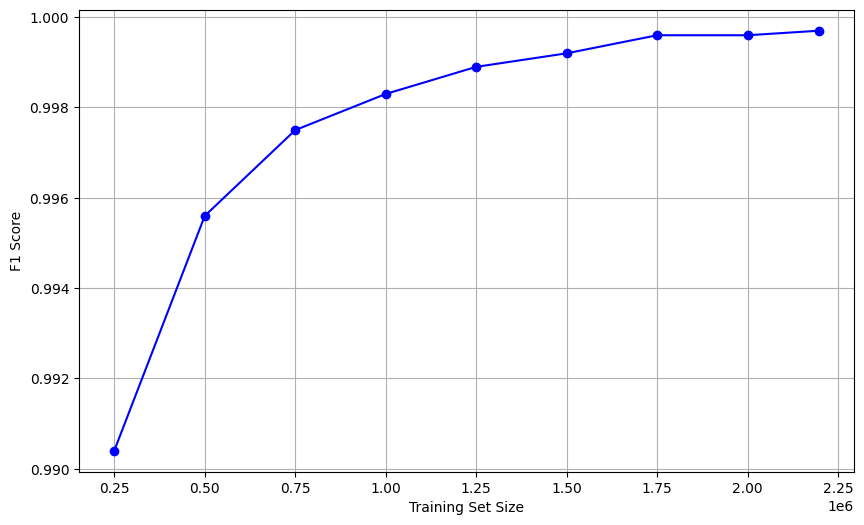

In [ ]:
# Data sizes and corresponding F1 scores
data_sizes = [250000, 500000, 750000, 1000000, 1250000, 1500000, 1750000, 2000000, 2196311]
f1_scores = [0.9904, 0.9956, 0.9975, 0.9983, 0.9989, 0.9992, 0.9996, 0.9996, 0.9997]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(data_sizes, f1_scores, marker='o', linestyle='-', color='b')

# Add titles and labels
# plt.title('F1 Score vs Data Size')
plt.xlabel('Training Set Size')
plt.ylabel('F1 Score')

# Display the plot
plt.grid(True)
plt.show()


## IV. Testing Classifiers on Unseen Attack (Novel) Types

In [2]:
# Load balanced data
balanced_df = pd.read_csv('./data/max_balanced_data.csv')

In [5]:
df_balanced = clean_data(balanced_df)

In [6]:
df_balanced.shape

(2196390, 41)

In [7]:
# Function to prepare data for binary classification models
def prepare_data_for_classification2(df):
    """
    Function to prepare data for binary classification models
    
    Args:
        df (DataFrame): DataFrame containing all the data
    
    Returns:
        df (DataFrame): DataFrame containing the processed data ready for classification
    """

    # Extract the number of classes in the classification problem
    # outcome_num  

    df2 = df.copy()
    
    ### Map class names to labels
    # Create a dictionary to map 'BenignTraffic' to 'begin' and other classes to 'attack'
    class_mapping = {'DictionaryBruteForce': 'attack',
                    'Backdoor_Malware': 'attack',
                    'Uploading_Attack': 'attack',
                    'CommandInjection': 'attack',
                    'VulnerabilityScan': 'attack',
                    'Recon-PingSweep': 'attack',
                    'SqlInjection': 'attack',
                    'BrowserHijacking': 'attack',
                    'DDoS-SlowLoris': 'attack',
                    'DDoS-HTTP_Flood': 'attack',
                    'Mirai-udpplain': 'attack',
                    'DDoS-UDP_Fragmentation': 'attack',
                    'DDoS-UDP_Flood': 'attack',
                    'MITM-ArpSpoofing': 'attack',
                    'XSS': 'attack',
                    'DNS_Spoofing': 'attack',
                    'Recon-HostDiscovery': 'attack',
                    'Recon-OSScan': 'attack',
                    'DoS-HTTP_Flood': 'attack',
                    'DDoS-ACK_Fragmentation': 'attack',
                    'Mirai-greip_flood': 'attack',
                    'Recon-PortScan': 'attack',
                    'DDoS-ICMP_Fragmentation': 'attack',
                    'DoS-UDP_Flood': 'attack',
                    'DoS-SYN_Flood': 'attack',
                    'DDoS-PSHACK_Flood': 'attack',
                    'DDoS-SynonymousIP_Flood': 'attack',
                    'DDoS-TCP_Flood': 'attack',
                    'DDoS-SYN_Flood': 'attack',
                    'Mirai-greeth_flood': 'attack',
                    'DDoS-ICMP_Flood': 'attack',
                    'DoS-TCP_Flood': 'attack',
                    'DDoS-RSTFINFlood': 'attack',
                    'BenignTraffic': 'benign'}
    df2['targt_var'] = df2['label'].map(class_mapping)
  
    
    # Fit an encoder to the target labels
    target_encoder = LabelEncoder()
    target_encoder.fit(df2['targt_var'])

    # Make sure that begnin is encoded as 0
    # Check if 'benign' is not the first element
    if target_encoder.classes_[0] != 'benign':
        # Find the index of 'benign'
        benign_index = list(target_encoder.classes_).index('benign')
        # Swap 'benign' with the first element
        target_encoder.classes_[0], target_encoder.classes_[benign_index] = target_encoder.classes_[benign_index], target_encoder.classes_[0]

    # Apply the encoder to the target variable to transform labels to integers
    df2['targt_var'] = target_encoder.transform(df2['targt_var'])

    # Display the dimensions of the DataFrame
    print("Dimensions:", df2.shape)
    
    # print unique target values with their original names using target_encoder
    target_encoded_labels = df2['targt_var'].unique()
    target_labels = target_encoder.inverse_transform(target_encoded_labels)
    target_mapping = dict(zip(target_encoded_labels, target_labels))
    print("\nMapping from encoded labels to original labels:")
    # Sort the dictionary by keys before printing
    for key, value in sorted(target_mapping.items()):
        print(key, ":", value)

    return df2

In [8]:
df_balanced = prepare_data_for_classification2(df_balanced)

Dimensions: (2196390, 42)

Mapping from encoded labels to original labels:
0 : benign
1 : attack


In [23]:
### Train RandomForestClassifier using the preprocessed balanced data
perf_all_rf_zerodays, perf_per_attack_subtype_rf_zerodays, perf_agg_rf_zerodays, aggregate_conf_matrix_rf_zerodays \
= train_classification_zerodays(df = df_balanced,
                                classifier = RandomForestClassifier(random_state=1, n_jobs=-1),
                                nfold_cv = 5,
                                random_state = 1)

----------------------
Evaluation CV Fold 1:
----------------------


2) Evaluation results for fold 1:
----------------------------------

Accuracy: 0.9983, AUC Score: 0.9997, recall: 0.9987, Precision: 0.9975, F1 Score: 0.9981

Evaluation Fold 1 took 173.2 seconds

----------------------
Evaluation CV Fold 2:
----------------------


2) Evaluation results for fold 2:
----------------------------------

Accuracy: 0.9983, AUC Score: 0.9997, recall: 0.9987, Precision: 0.9976, F1 Score: 0.9982

Evaluation Fold 2 took 163.4 seconds

----------------------
Evaluation CV Fold 3:
----------------------


2) Evaluation results for fold 3:
----------------------------------

Accuracy: 0.9982, AUC Score: 0.9997, recall: 0.9986, Precision: 0.9973, F1 Score: 0.9980

Evaluation Fold 3 took 161.0 seconds

----------------------
Evaluation CV Fold 4:
----------------------


2) Evaluation results for fold 4:
----------------------------------

Accuracy: 0.9983, AUC Score: 0.9997, recall: 0.9987, Pre

In [24]:
perf_agg_rf_zerodays

,Accuracy,AUC Score,Recall,Precision,F1 Score
mean,0.9983,0.9997,0.9987,0.9975,0.9981
std,0.0001,0.0000,0.0001,0.0001,0.0001


In [36]:
# Performance metrics for the zero-day attacks
perf_per_attack_subtype_rf_zerodays.loc[['DDoS-PSHACK_Flood', 'DDoS-RSTFINFlood', 'DDoS-UDP_Fragmentation',
                                         'Mirai-greeth_flood', 'Mirai-greip_flood', 'Mirai-udpplain']].round(4)

,Accuracy,Recall,Precision,F1 Score,Test Sample Size
Subtype,,,,,
DDoS-PSHACK_Flood,1.0000,1.0000,1.0,1.0000,98640.0
DDoS-RSTFINFlood,1.0000,1.0000,1.0,1.0000,97448.0
DDoS-UDP_Fragmentation,0.9993,0.9993,1.0,0.9997,6912.0
Mirai-greeth_flood,1.0000,1.0000,1.0,1.0000,23893.0
Mirai-greip_flood,1.0000,1.0000,1.0,1.0000,18108.0
Mirai-udpplain,1.0000,1.0000,1.0,1.0000,21453.0


### Get the performance metrics for the binary calssification with only known attack types

In [29]:
def train_classification_binary(df = df_balanced,
                                classifier = RandomForestClassifier(), 
                                nfold_cv = 5,
                                random_state = 1):
    """
    Train binary classification algorithms with k-fold cross-validation 

    Args:
    df (DataFrame): DataFrame containing the data ()
    classifier (sklearn model): sklearn model to be used (e.g. RandomForestClassifier())
    nfold_cv (int): number of folds for cross-validation
    random_state (int): random state for reproducibility

    Returns:
    performance_all (dataframe): performance of the model for each fold
    performance_agg (dataframe): average and std of the performance metrics over the 5 folds
    performance_per_attack_subtype (dataframe): performance of the model for each attack subtype
    aggregate_conf_matrix (array): aggregate confusion matrix over the 5 folds
    """
    
    
    ### Extract feature columns and target column
    X = df.drop(['targt_var', 'label'], axis=1)
    y = df['targt_var']
    labels = df['label']
    
    # Start the timer
    start = time.time()

    # Initialise Stratified 5-Fold cross-validator
    skf = StratifiedKFold(n_splits = nfold_cv, shuffle = True, random_state = random_state)

    # Lists to store the metrics for each fold
    accuracies = []
    recalls = []
    precisions = []
    f1_scores = []
    auc_scores = []
    attack_subtype_metrics = []

    # number of classes (benign and attack)
    num_classes = 2

    # Initialise an empty confusion matrix to accumulate all the values from the 5 folds
    aggregate_conf_matrix = np.zeros((num_classes, num_classes), dtype=int)

    # Perform k-fold cross-validation
    for train_index, test_index in skf.split(X, y):

        # Start the timer
        start = time.time()

        # Print a message at the start of Evaluation CV iteration to show the fold number
        print("----------------------")
        print("Evaluation CV Fold {}:".format(len(accuracies)+1))
        print("----------------------\n")

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        labels_test = labels.iloc[test_index]

        # Fit the model
        classifier.fit(X_train, y_train)
        
        # Make predictions with the best model
        y_pred = classifier.predict(X_test)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)
        y_pred_proba = classifier.predict_proba(X_test)[:, 1]
        auc_score = roc_auc_score(y_test, y_pred_proba)

        precision = precision_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')
        
        # Append metrics to lists
        accuracies.append(accuracy)
        recalls.append(recall)
        auc_scores.append(auc_score)
        precisions.append(precision)
        f1_scores.append(f1)
        aggregate_conf_matrix += conf_matrix

        # Subtype-specific metrics
        for subtype in labels_test.unique():
            subtype_indices = labels_test.index[labels_test == subtype]
            y_subtype_true = y_test.loc[subtype_indices]
            y_subtype_pred = pd.Series(y_pred, index=y_test.index).loc[subtype_indices]
            
            subtype_accuracy = accuracy_score(y_subtype_true, y_subtype_pred)

            # Calculate the recall, precision and f1 score for both benign and attack
            if subtype == "BenignTraffic": # if the subtype is benign, set pos_label to 0
                subtype_recall = recall_score(y_subtype_true, y_subtype_pred, pos_label=0)
                subtype_precision = precision_score(y_subtype_true, y_subtype_pred, pos_label=0)
                subtype_f1 = f1_score(y_subtype_true, y_subtype_pred, pos_label=0)
            else:
                subtype_recall = recall_score(y_subtype_true, y_subtype_pred)
                subtype_precision = precision_score(y_subtype_true, y_subtype_pred)
                subtype_f1 = f1_score(y_subtype_true, y_subtype_pred)
            
            attack_subtype_metrics.append({
                "Subtype": subtype,
                "Accuracy": subtype_accuracy,
                "Recall": subtype_recall,
                "Precision": subtype_precision,
                "F1 Score": subtype_f1,
                "Test Sample Size": len(subtype_indices)
            })
        

        # Print a message at the end of CV iteration to show the fold number, run time, the accuracy and the best hyperparameters
        print("\n2) Evaluation results for fold {}:".format(len(accuracies)))
        print("----------------------------------\n")
        print("Accuracy: {:.4f}, AUC Score: {:.4f}, recall: {:.4f}, Precision: {:.4f}, F1 Score: {:.4f}".format(
            accuracy, auc_score, recall, precision, f1))
        print("\nEvaluation Fold {} took {:.1f} seconds\n".format(len(accuracies), time.time() - start))     

    # Create a dataframe that stores the performance of rf model for each fold
    performance_all = pd.DataFrame({
        "Accuracy": accuracies,
        "AUC Score": auc_scores,
        "Recall": recalls,
        "Precision": precisions,
        "F1 Score": f1_scores
    })  

    # Create a dataframe that stores the average and std of all metrics over the 5 folds. Limit the number of decimal places to 3
    performance_agg = performance_all.describe().loc[['mean', 'std']].round(4)

    # Place holder for performance_per_attack_subtype
    performance_per_attack_subtype = pd.DataFrame(attack_subtype_metrics).groupby("Subtype").mean()

    # Replace mean test sample size with the median test sample size
    performance_per_attack_subtype['Test Sample Size'] = pd.DataFrame(attack_subtype_metrics).groupby("Subtype").median()['Test Sample Size']

    return performance_all, performance_per_attack_subtype, performance_agg, aggregate_conf_matrix

In [30]:
# Train RandomForestClassifier using the preprocessed balanced data
perf_all_rf, perf_per_attack_subtype_rf, perf_agg_rf, aggregate_conf_matrix_rf \
= train_classification_binary(df = df_balanced,
                              classifier = RandomForestClassifier(random_state=1, n_jobs=-1),
                              nfold_cv = 5,
                              random_state = 1)

----------------------
Evaluation CV Fold 1:
----------------------


2) Evaluation results for fold 1:
----------------------------------

Accuracy: 0.9974, AUC Score: 0.9994, recall: 0.9974, Precision: 0.9974, F1 Score: 0.9974

Evaluation Fold 1 took 173.6 seconds

----------------------
Evaluation CV Fold 2:
----------------------


2) Evaluation results for fold 2:
----------------------------------

Accuracy: 0.9974, AUC Score: 0.9994, recall: 0.9974, Precision: 0.9974, F1 Score: 0.9974

Evaluation Fold 2 took 164.1 seconds

----------------------
Evaluation CV Fold 3:
----------------------


2) Evaluation results for fold 3:
----------------------------------

Accuracy: 0.9975, AUC Score: 0.9995, recall: 0.9975, Precision: 0.9975, F1 Score: 0.9975

Evaluation Fold 3 took 166.9 seconds

----------------------
Evaluation CV Fold 4:
----------------------


2) Evaluation results for fold 4:
----------------------------------

Accuracy: 0.9975, AUC Score: 0.9995, recall: 0.9975, Pre

In [31]:
perf_agg_rf

,Accuracy,AUC Score,Recall,Precision,F1 Score
mean,0.9974,0.9994,0.9974,0.9975,0.9974
std,0.0001,0.0000,0.0001,0.0001,0.0001


In [37]:
# Show the performance metrics for the zero-day attacks
perf_per_attack_subtype_rf.loc[['DDoS-PSHACK_Flood', 'DDoS-RSTFINFlood', 'DDoS-UDP_Fragmentation',
                                         'Mirai-greeth_flood', 'Mirai-greip_flood', 'Mirai-udpplain']].round(4)

,Accuracy,Recall,Precision,F1 Score,Test Sample Size
Subtype,,,,,
DDoS-PSHACK_Flood,1.0000,1.0000,1.0,1.0000,19741.0
DDoS-RSTFINFlood,1.0000,1.0000,1.0,1.0000,19509.0
DDoS-UDP_Fragmentation,0.9999,0.9999,1.0,0.9999,1364.0
Mirai-greeth_flood,1.0000,1.0000,1.0,1.0000,4811.0
Mirai-greip_flood,1.0000,1.0000,1.0,1.0000,3627.0
Mirai-udpplain,1.0000,1.0000,1.0,1.0000,4283.0
